In [1]:
from pyspark.sql import SparkSession
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [2]:
import socket
port = spark.sparkContext.uiWebUrl.split(":")[-1]
hostname = socket.gethostname()
print(f"https://{hostname}/jupyter/user/stevengs/proxy/{port}/jobs/")

https://epyc.astro.washington.edu/jupyter/user/stevengs/proxy/4048/jobs/


In [3]:
import axs
from fit_utils import plot_fit_result
import matplotlib.pyplot as plt
import numpy as np

In [5]:
catalog = axs.AxsCatalog(spark)
top_hat_fits = catalog.load("6_4_20_stevengs_top_hat_fits_r_band")

In [6]:
from models import top_hat

Row(sum_square_error=247.6127166748047, reduced_sum_square_error=1.0672962665557861)


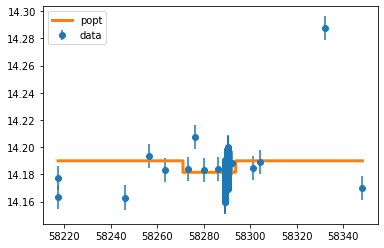

In [8]:
_lc = top_hat_fits.head(1)[0]
x = _lc['around_dip_window_r']['x']
y = _lc['around_dip_window_r']['y']
yerr = _lc['around_dip_window_r']['yerr']
fit = _lc['fit_r']
plot_fit_result(
    x, y, yerr, 
    fit, top_hat
)
print(_lc['model_error_in_dip_r'])

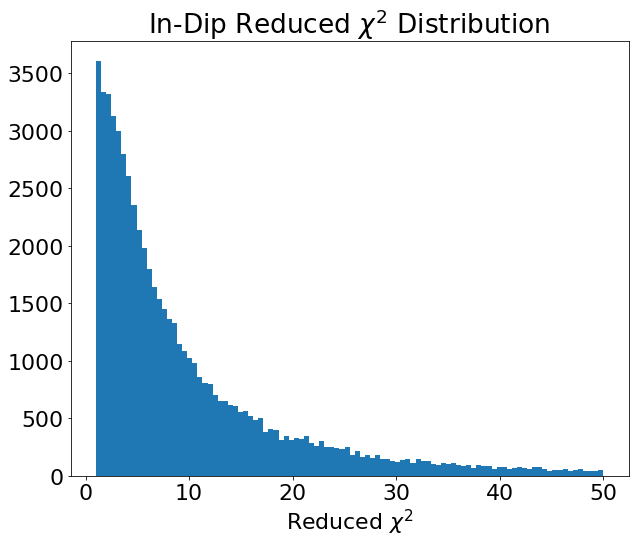

In [13]:
chi_sq = top_hat_fits.select(top_hat_fits['model_error_in_dip_r']).collect()
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=22)
plt.hist([_['model_error_in_dip_r']['reduced_sum_square_error'] for _ in chi_sq], bins=100, range=(1, 50))
plt.title("In-Dip Reduced $\chi^2$ Distribution")
plt.xlabel("Reduced $\chi^2$")
plt.show()

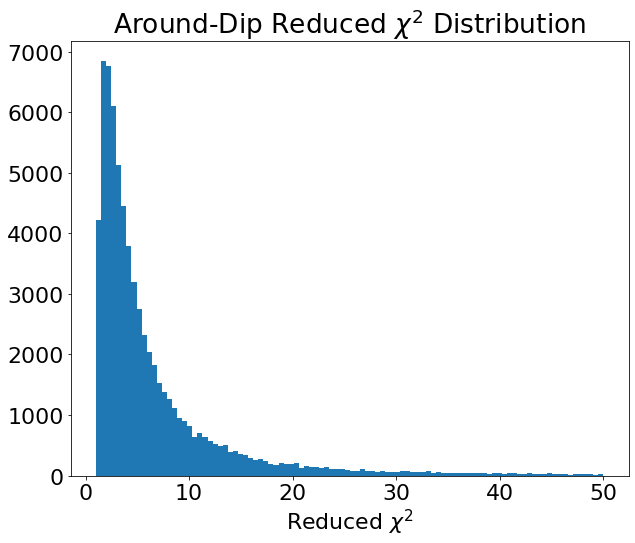

In [14]:
chi_sq = top_hat_fits.select(top_hat_fits['model_error_around_dip_r']).collect()
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=22)
plt.hist([_['model_error_around_dip_r']['reduced_sum_square_error'] for _ in chi_sq], bins=100, range=(1, 50))
plt.title("Around-Dip Reduced $\chi^2$ Distribution")
plt.xlabel("Reduced $\chi^2$")
plt.show()

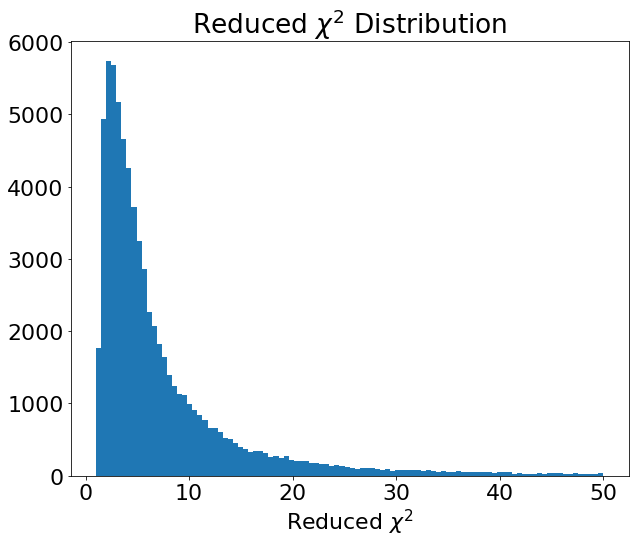

In [15]:
chi_sq = top_hat_fits.select(top_hat_fits['model_error_r']).collect()
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=22)
plt.hist([_['model_error_r']['reduced_sum_square_error'] for _ in chi_sq], bins=100, range=(1, 50))
plt.title("Reduced $\chi^2$ Distribution")
plt.xlabel("Reduced $\chi^2$")
plt.show()

# Cut data using in-dip $\chi^2$

In [16]:
fits_to_show = top_hat_fits.where(
    (top_hat_fits['model_error_in_dip_r.reduced_sum_square_error'] < 10)
).sort(
    top_hat_fits['model_error_in_dip_r.reduced_sum_square_error'],
    ascending=True
)

In [17]:
fits_to_show_in_memory = fits_to_show.collect()


    id                   = 85022588485331000
    dip.significance     = 7.693305492401123
    model_error_in_dip_r = 0.26106715202331543
    


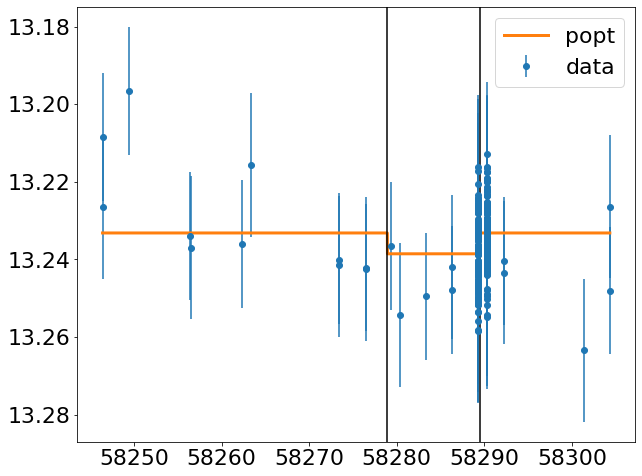


    id                   = 85022588485331000
    dip.significance     = 7.693305492401123
    model_error_in_dip_r = 0.26106715202331543
    


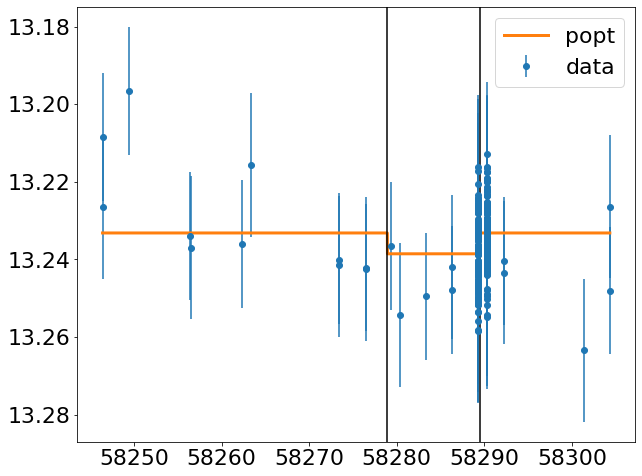


    id                   = 162440509552616452
    dip.significance     = 7.8653435707092285
    model_error_in_dip_r = 0.28713616728782654
    


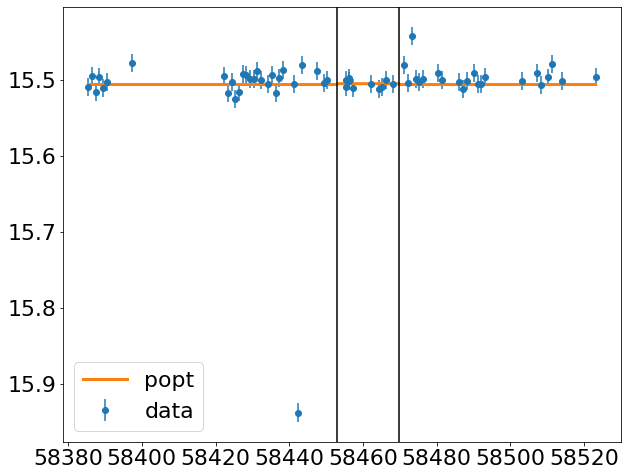


    id                   = 107402834045122313
    dip.significance     = 5.990357875823975
    model_error_in_dip_r = 0.2944592535495758
    


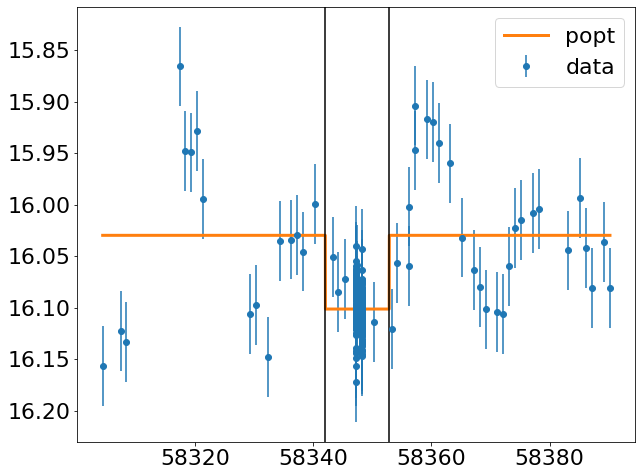


    id                   = 107402834045122313
    dip.significance     = 5.990357875823975
    model_error_in_dip_r = 0.2944592535495758
    


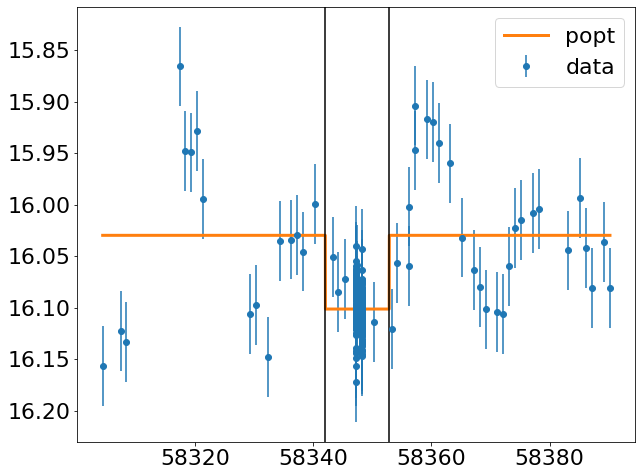


    id                   = 106492848594340782
    dip.significance     = 9.10241985321045
    model_error_in_dip_r = 0.3055568039417267
    


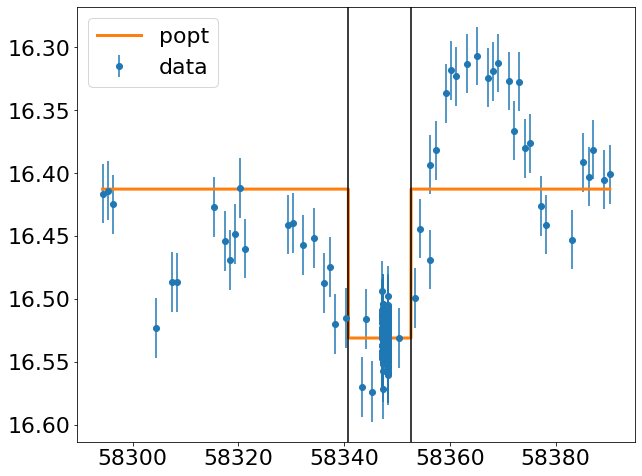


    id                   = 105772868691832500
    dip.significance     = 5.129798412322998
    model_error_in_dip_r = 0.3100071847438812
    


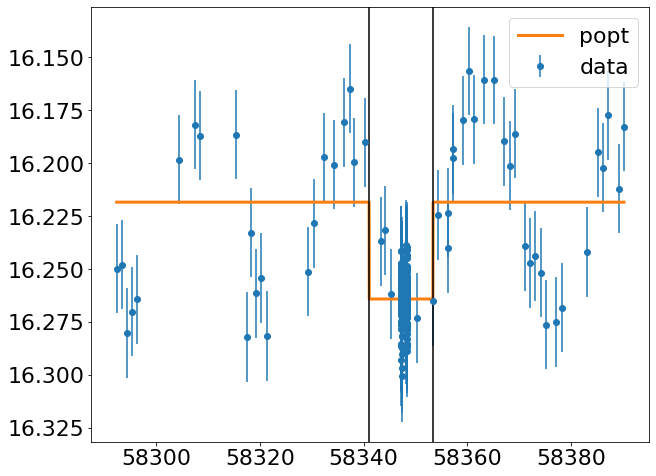


    id                   = 106512849196535327
    dip.significance     = 6.9887375831604
    model_error_in_dip_r = 0.32674217224121094
    


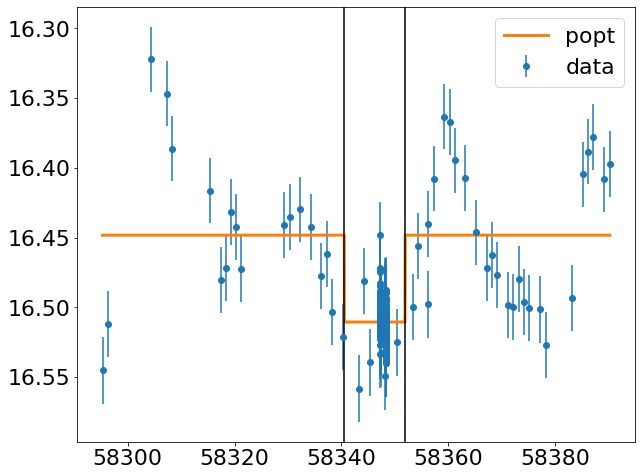


    id                   = 175483217901744344
    dip.significance     = 5.152000427246094
    model_error_in_dip_r = 0.3443549573421478
    


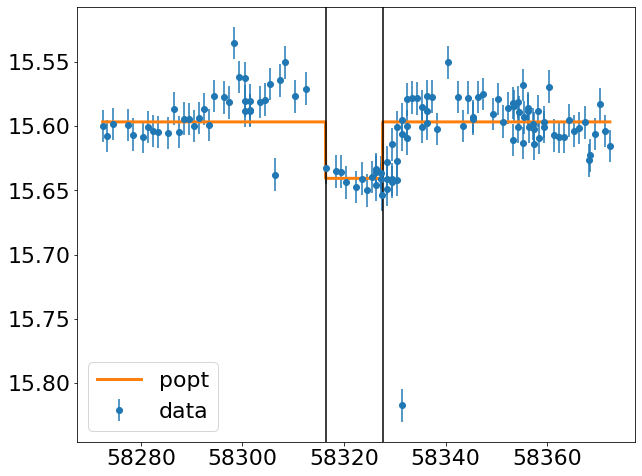


    id                   = 132562947062080207
    dip.significance     = 12.597034454345703
    model_error_in_dip_r = 0.36245113611221313
    


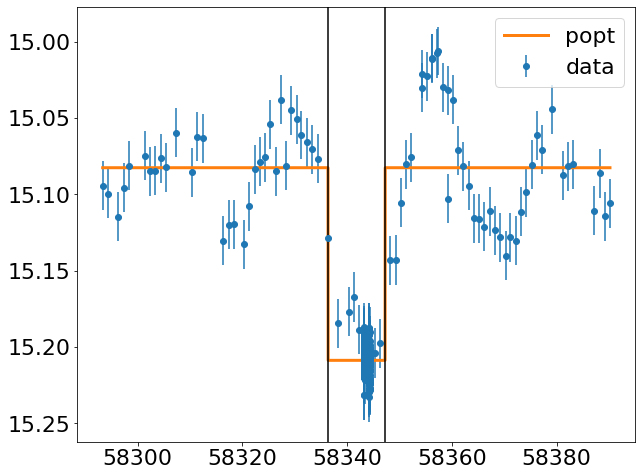

In [37]:
nplot = 0
total = 10
for lc in fits_to_show_in_memory:
    if nplot == total:
        break
    x = lc['around_dip_window_r']['x']
    if len(lc['dip_window_r']['x']) < 10:
        continue
    nplot += 1
        
    y = lc['around_dip_window_r']['y']
    yerr = lc['around_dip_window_r']['yerr']
    fit = lc['fit_r']
    plot_fit_result(
        x, y, yerr, 
        fit, top_hat
    )

    dip = lc['dip']
    
    plt.axvline(dip['start_mjd'], color="k", label="start")
    plt.axvline(dip['end_mjd'], color="k", label="end")
    print("""
    id                   = {}
    dip.significance     = {}
    model_error_in_dip_r = {}
    """.format(
        lc['ps1_objid'],
        dip['significance'],
        lc['model_error_in_dip_r']['reduced_sum_square_error']
    ))
    plt.gca().invert_yaxis()
    plt.show()

# Cut data using in-window $\chi^2$

In [27]:
fits_to_show_window_error = top_hat_fits.where(
    # chi_square / ndof < 5
    (top_hat_fits['model_error_around_dip_r.reduced_sum_square_error'] < 5)
).cache().sort(
    top_hat_fits['dip.reduced_sum_square_error'],
    ascending=True
)

In [28]:
fits_to_show_window_error_in_memory = fits_to_show_window_error.collect()

In [29]:
len(fits_to_show_window_error_in_memory)

41823


    dip.significance     = 6.008080005645752
    model_error_around_dip_r = 0.2606598436832428
    


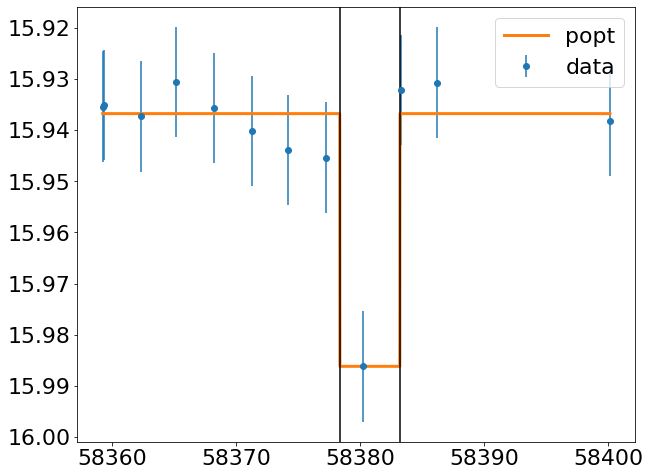


    dip.significance     = 7.583601951599121
    model_error_around_dip_r = 0.2612839937210083
    


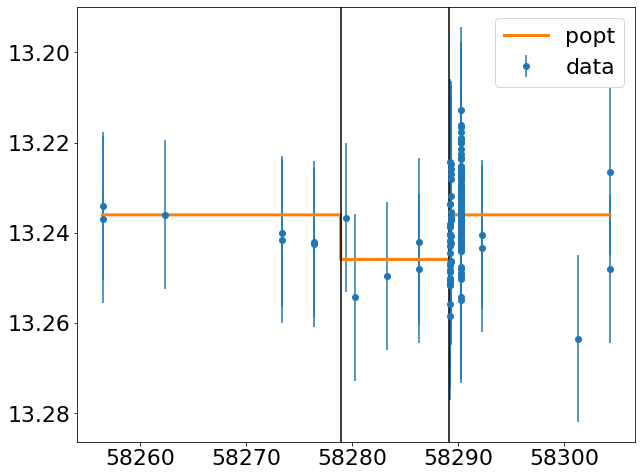


    dip.significance     = 7.583601951599121
    model_error_around_dip_r = 0.2612839937210083
    


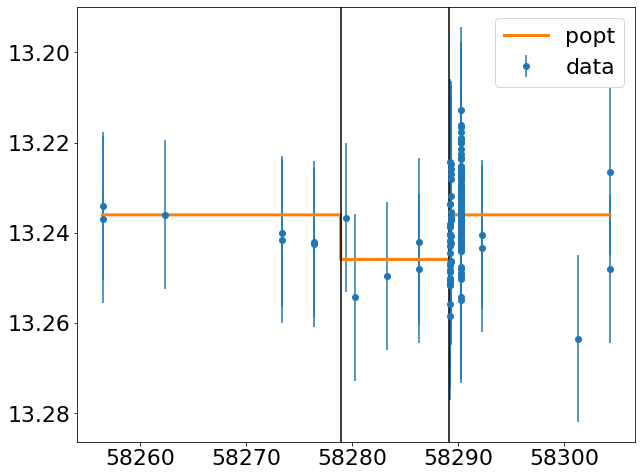


    dip.significance     = 7.693305492401123
    model_error_around_dip_r = 0.2781117260456085
    


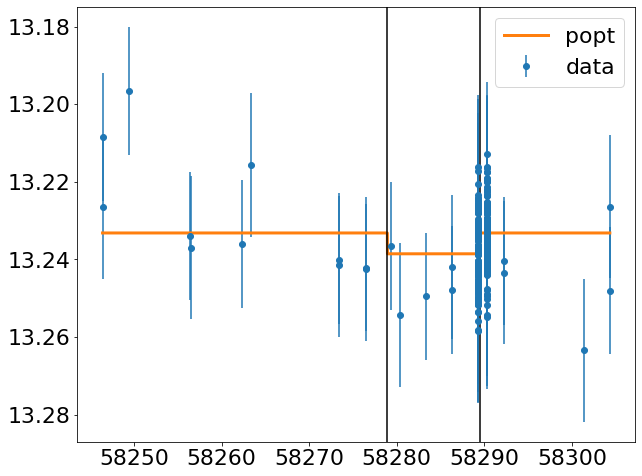


    dip.significance     = 7.693305492401123
    model_error_around_dip_r = 0.2781117260456085
    


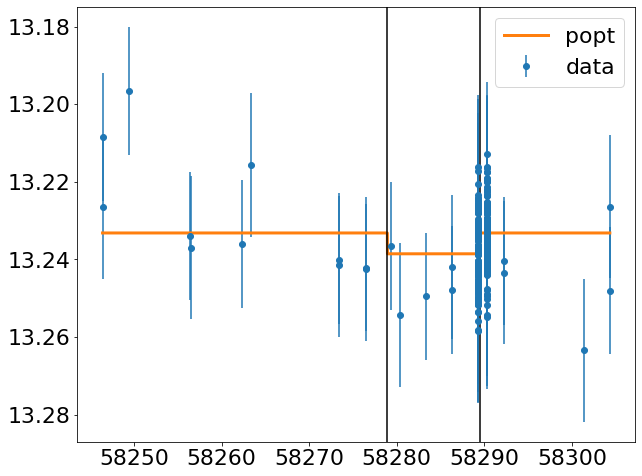

In [33]:
nplot = 0
total = 5
for lc in fits_to_show_window_error_in_memory:
    if nplot == total:
        break
    x = lc['around_dip_window_r']['x']
    nplot += 1
        
    y = lc['around_dip_window_r']['y']
    yerr = lc['around_dip_window_r']['yerr']
    fit = lc['fit_r']
    plot_fit_result(
        x, y, yerr, 
        fit, top_hat
    )

    dip = lc['dip']
    
    plt.axvline(dip['start_mjd'], color="k", label="start")
    plt.axvline(dip['end_mjd'], color="k", label="end")
    print("""
    id                       = {}
    dip.significance        = {}
    model_error_around_dip_r = {}
    """.format(
        lc['ps1_objid'],
        dip['significance'],
        lc['model_error_around_dip_r']['reduced_sum_square_error']
    ))
    
    plt.gca().invert_yaxis()
    plt.show()

Sorting by $\chi^2$ doesn't seem great. Sort by dip significance instead:

In [34]:
fits_to_show_window_error = top_hat_fits.where(
    # chi_square / ndof < 5
    (top_hat_fits['model_error_around_dip_r.reduced_sum_square_error'] < 5)
).cache().sort(
    top_hat_fits['dip.significance'],
    ascending=False
)

In [35]:
fits_to_show_window_error_in_memory = fits_to_show_window_error.collect()


    id                       = 131632931064144554
    dip.significance         = 41.55031967163086
    model_error_around_dip_r = 4.086984634399414
    


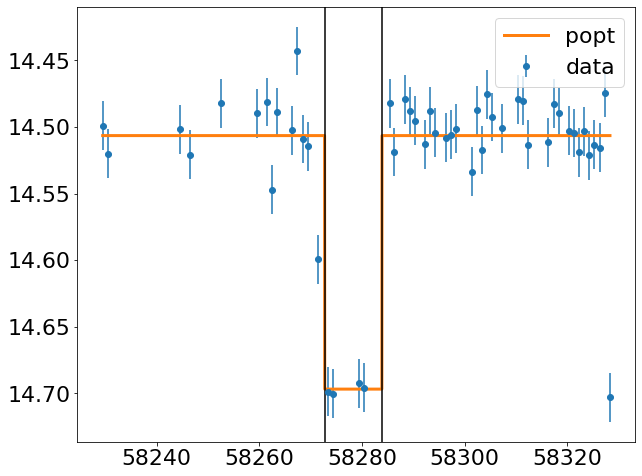


    id                       = 176463330831360418
    dip.significance         = 41.31840515136719
    model_error_around_dip_r = 4.2167487144470215
    


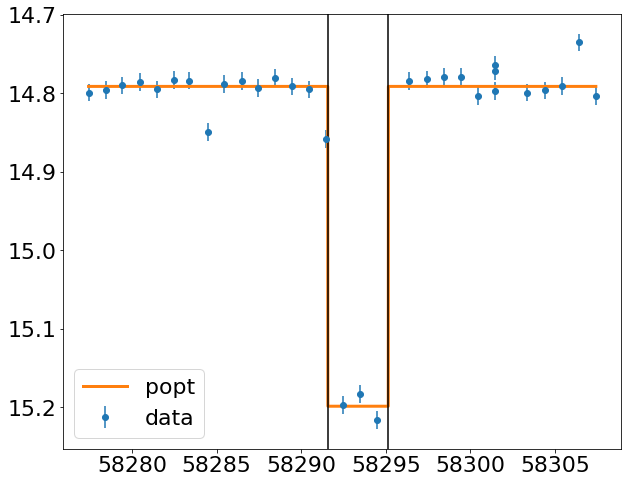


    id                       = 110832879727607699
    dip.significance         = 36.30021286010742
    model_error_around_dip_r = 3.064725637435913
    


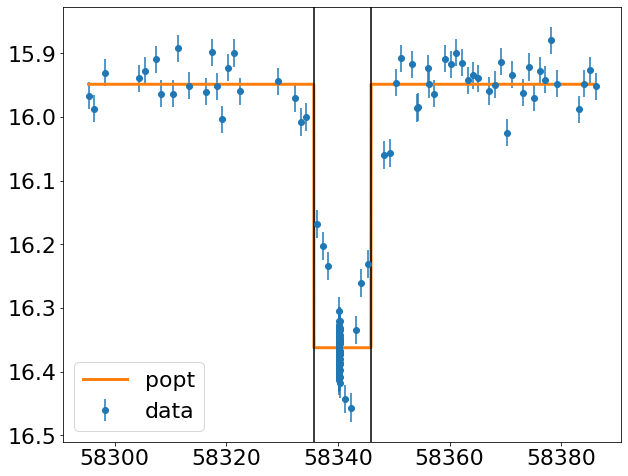


    id                       = 127542953512862009
    dip.significance         = 34.629695892333984
    model_error_around_dip_r = 1.9631927013397217
    


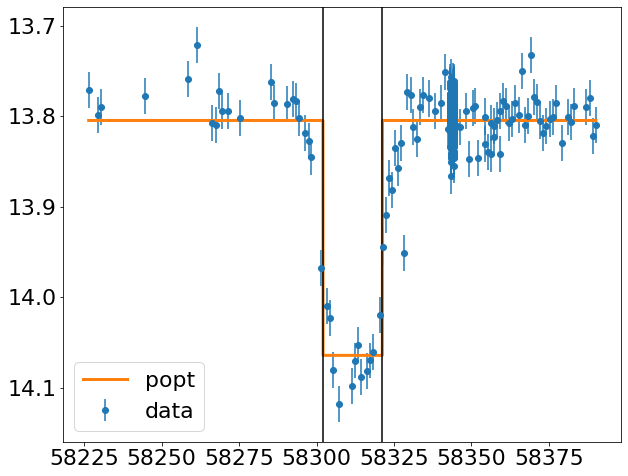


    id                       = 127542953512862009
    dip.significance         = 34.629695892333984
    model_error_around_dip_r = 1.9631927013397217
    


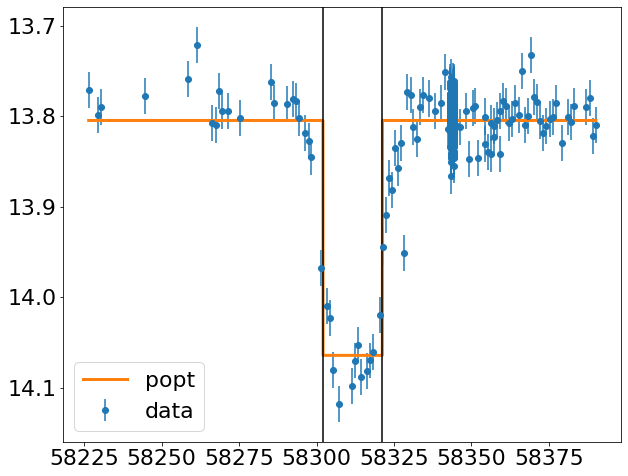


    id                       = 164413281268553432
    dip.significance         = 28.79938316345215
    model_error_around_dip_r = 4.1636433601379395
    


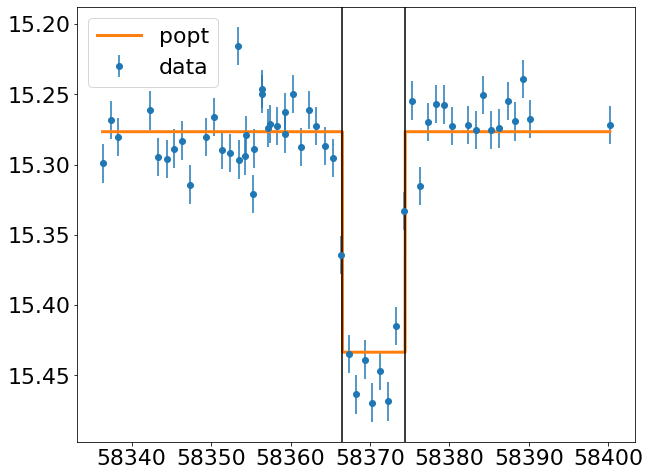


    id                       = 132562964576181153
    dip.significance         = 28.531173706054688
    model_error_around_dip_r = 3.819701671600342
    


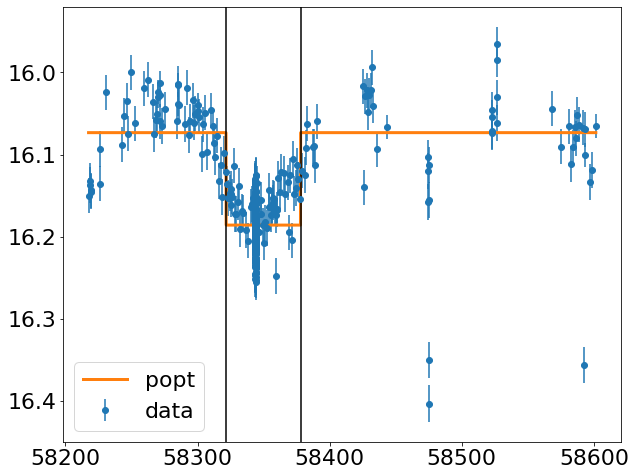


    id                       = 132562964576181153
    dip.significance         = 28.531173706054688
    model_error_around_dip_r = 3.819701671600342
    


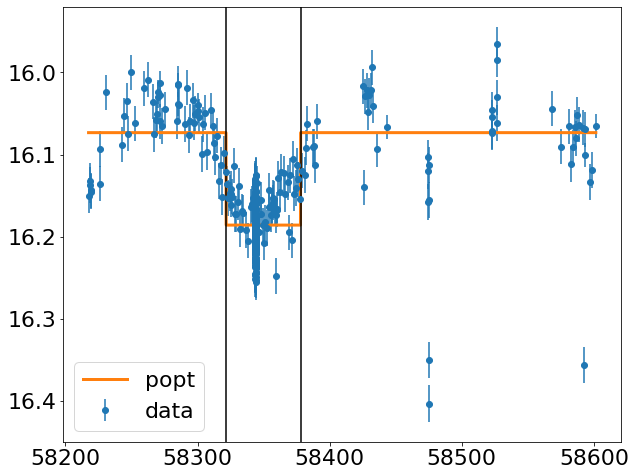


    id                       = 106222846742184617
    dip.significance         = 27.12019157409668
    model_error_around_dip_r = 3.527754783630371
    


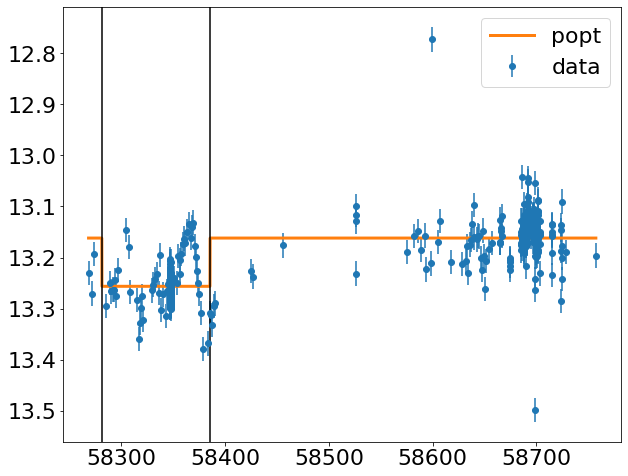


    id                       = 107611037749611530
    dip.significance         = 26.744962692260742
    model_error_around_dip_r = 4.918464660644531
    


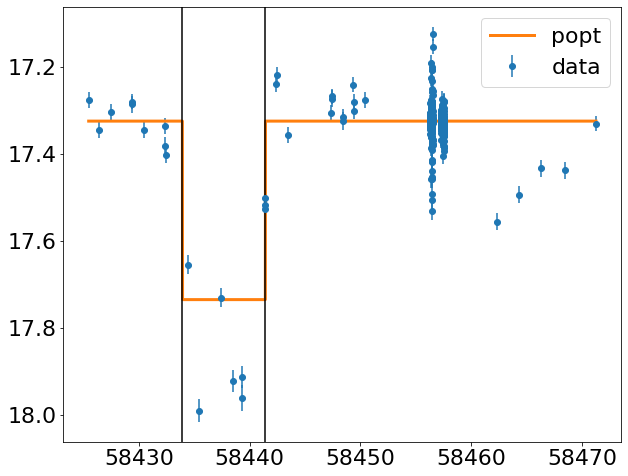


    id                       = 129882947896818809
    dip.significance         = 25.71099090576172
    model_error_around_dip_r = 2.146423578262329
    


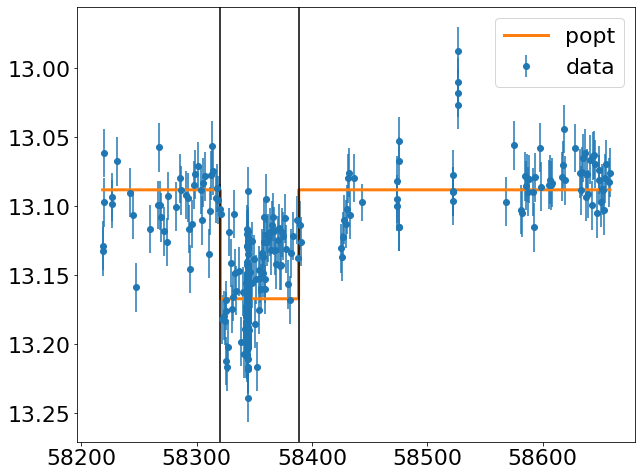


    id                       = 121362944148527847
    dip.significance         = 24.705665588378906
    model_error_around_dip_r = 2.276376485824585
    


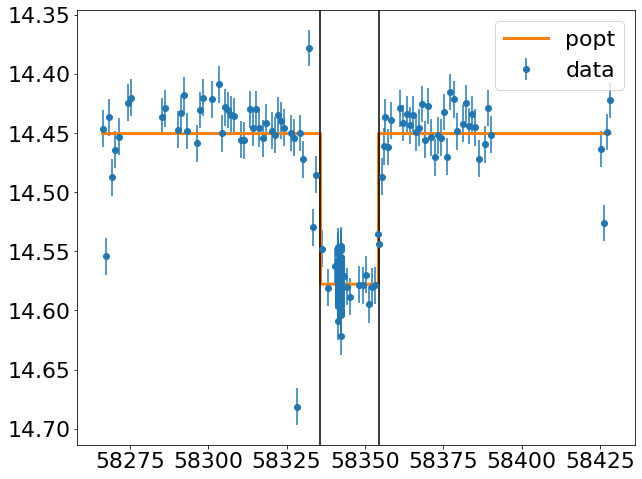


    id                       = 106902841719309637
    dip.significance         = 23.680742263793945
    model_error_around_dip_r = 4.478232383728027
    


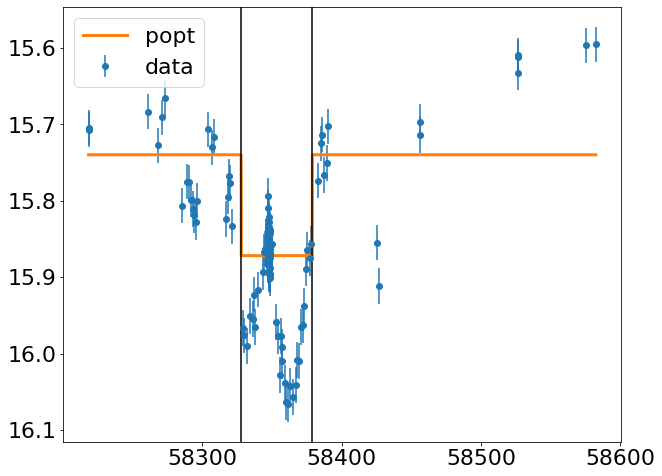


    id                       = 141372956871058006
    dip.significance         = 23.46469497680664
    model_error_around_dip_r = 0.8952544331550598
    


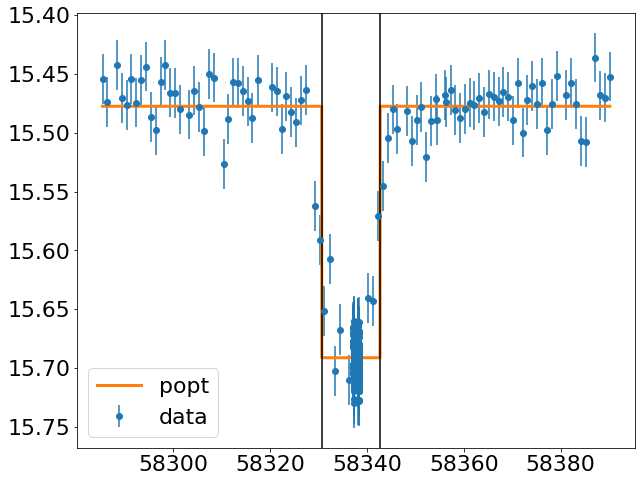


    id                       = 156030397349427234
    dip.significance         = 23.038328170776367
    model_error_around_dip_r = 4.0939860343933105
    


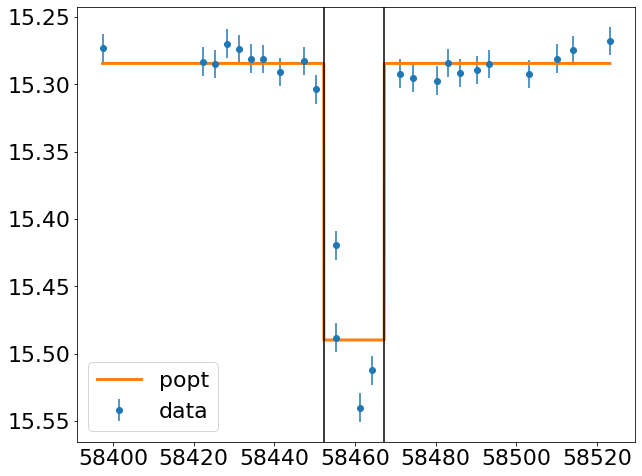


    id                       = 139782964550564763
    dip.significance         = 22.92140769958496
    model_error_around_dip_r = 3.0897481441497803
    


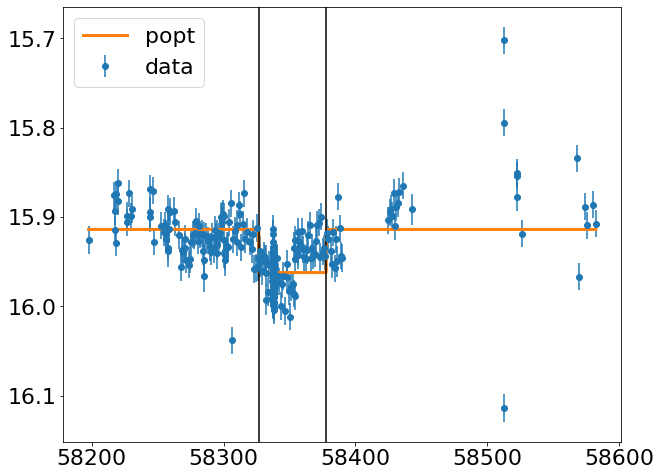


    id                       = 102002832164600717
    dip.significance         = 22.88143539428711
    model_error_around_dip_r = 4.512650012969971
    


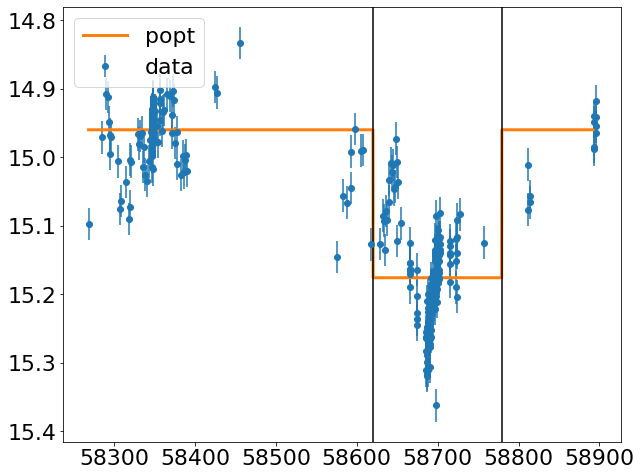


    id                       = 102002832164600717
    dip.significance         = 22.88143539428711
    model_error_around_dip_r = 4.512650012969971
    


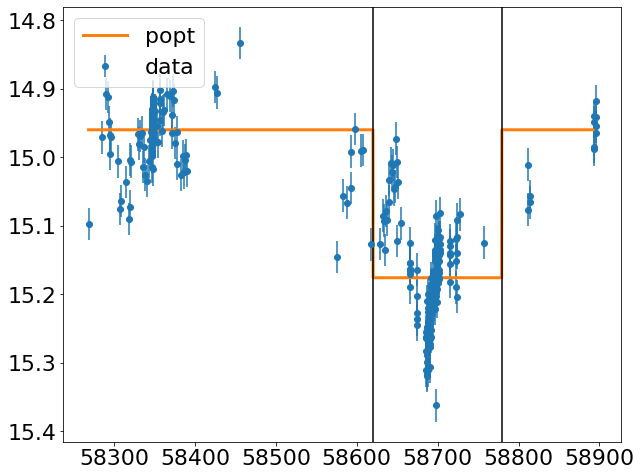


    id                       = 162283062480199475
    dip.significance         = 22.441946029663086
    model_error_around_dip_r = 4.689008712768555
    


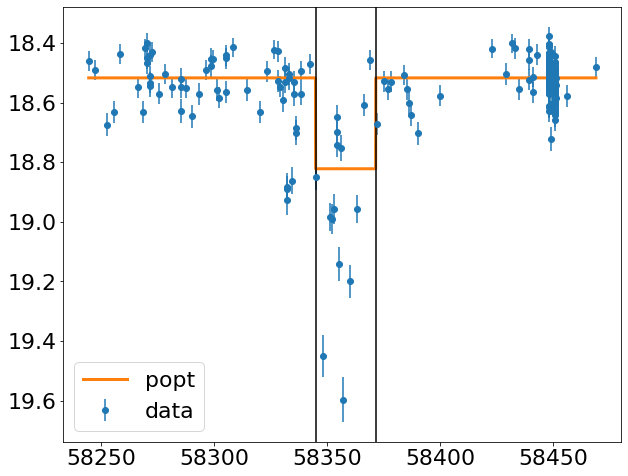


    id                       = 118402912511650954
    dip.significance         = 22.182559967041016
    model_error_around_dip_r = 2.4918525218963623
    


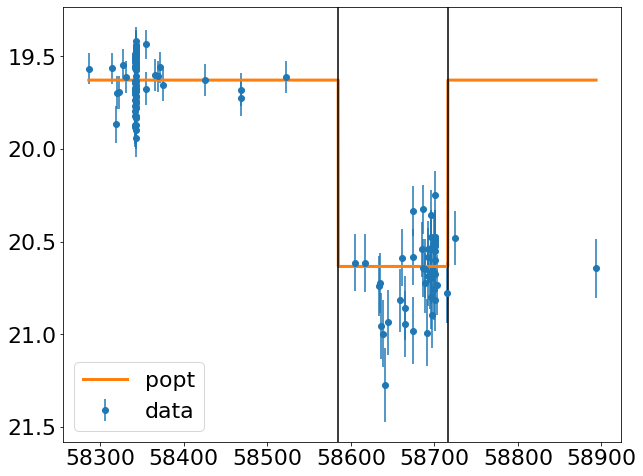


    id                       = 118402912511650954
    dip.significance         = 22.182559967041016
    model_error_around_dip_r = 2.4918525218963623
    


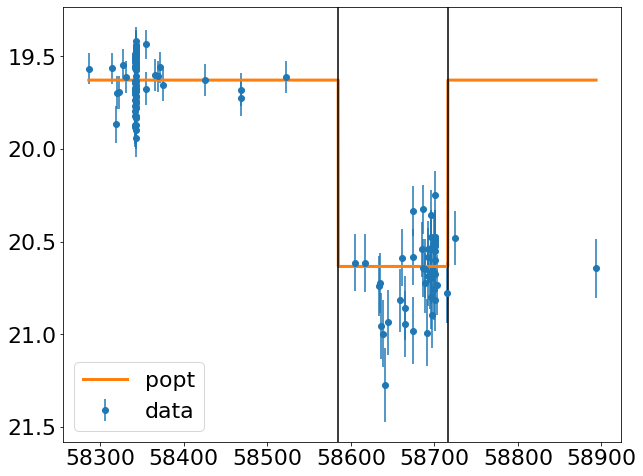


    id                       = 136442962646762214
    dip.significance         = 21.703048706054688
    model_error_around_dip_r = 3.7888100147247314
    


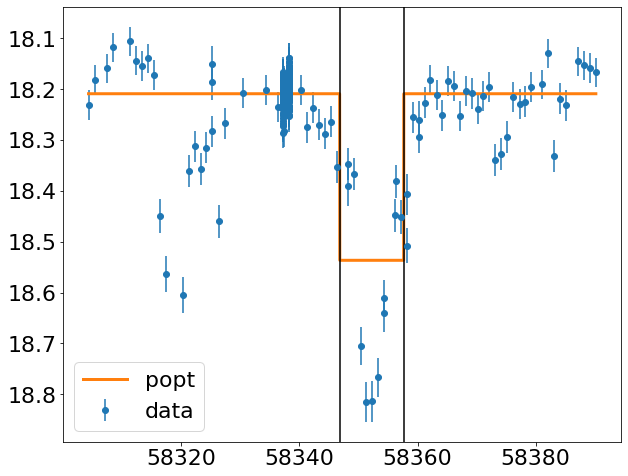


    id                       = 136442962646762214
    dip.significance         = 21.703048706054688
    model_error_around_dip_r = 3.7888100147247314
    


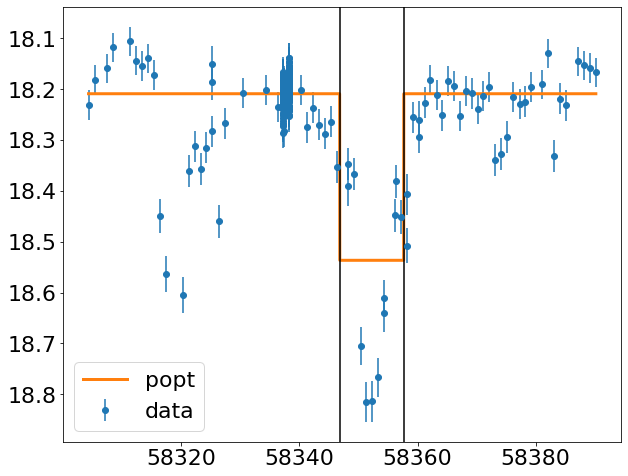


    id                       = 136392930630377629
    dip.significance         = 21.452255249023438
    model_error_around_dip_r = 1.205998420715332
    


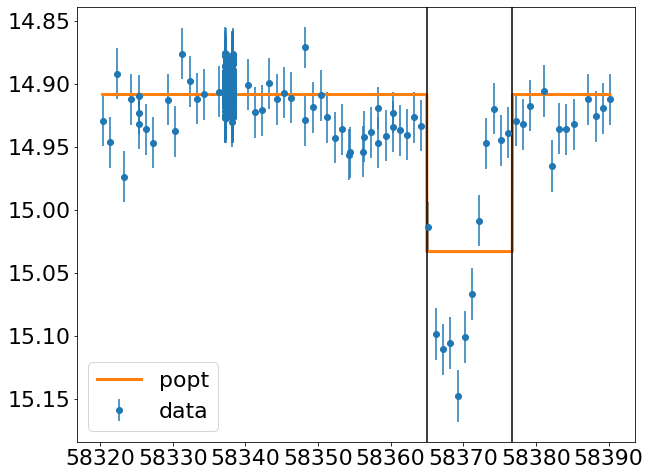


    id                       = 112792989151791549
    dip.significance         = 21.368377685546875
    model_error_around_dip_r = 3.520094871520996
    


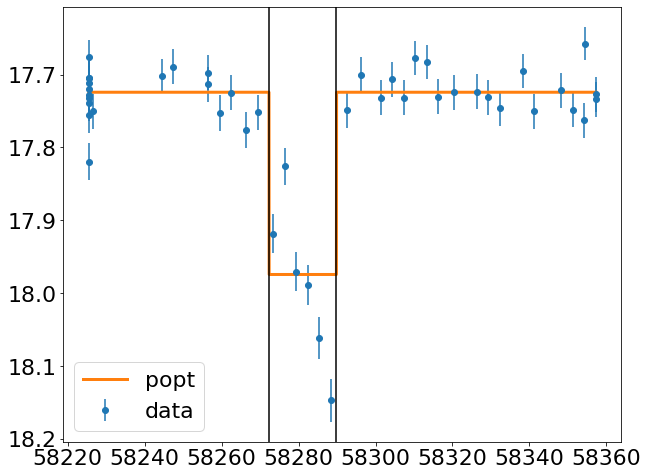


    id                       = 123722823891529289
    dip.significance         = 21.34234046936035
    model_error_around_dip_r = 4.106349468231201
    


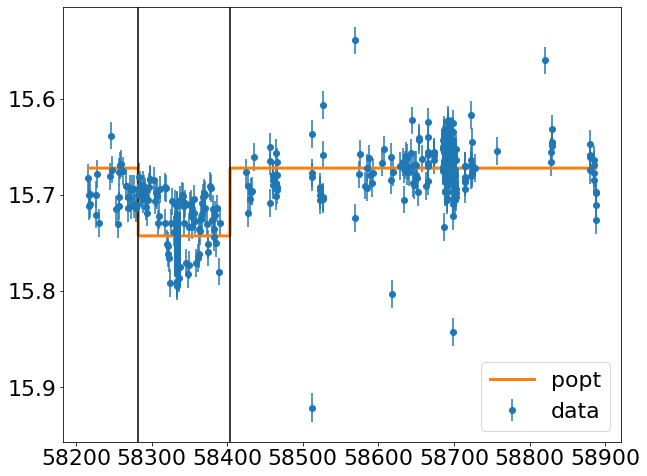


    id                       = 163293114554855616
    dip.significance         = 21.14653205871582
    model_error_around_dip_r = 4.102790355682373
    


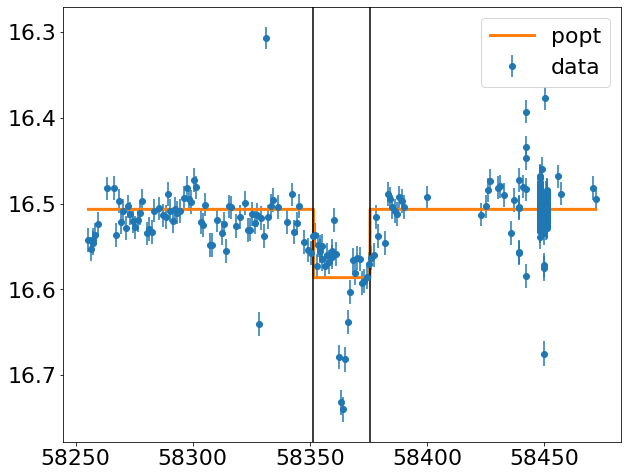


    id                       = 108112869521631235
    dip.significance         = 21.121496200561523
    model_error_around_dip_r = 4.830771446228027
    


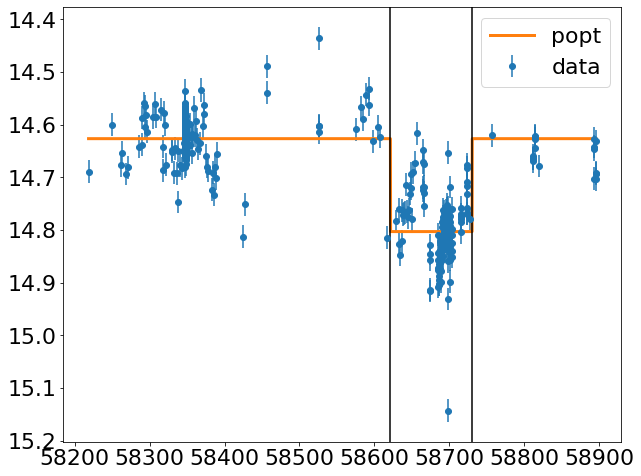


    id                       = 126132855879540957
    dip.significance         = 20.994558334350586
    model_error_around_dip_r = 3.859294891357422
    


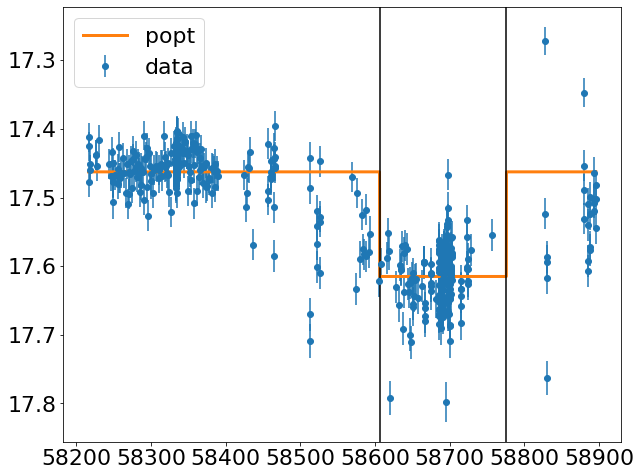


    id                       = 125352875383987299
    dip.significance         = 20.906274795532227
    model_error_around_dip_r = 4.481271743774414
    


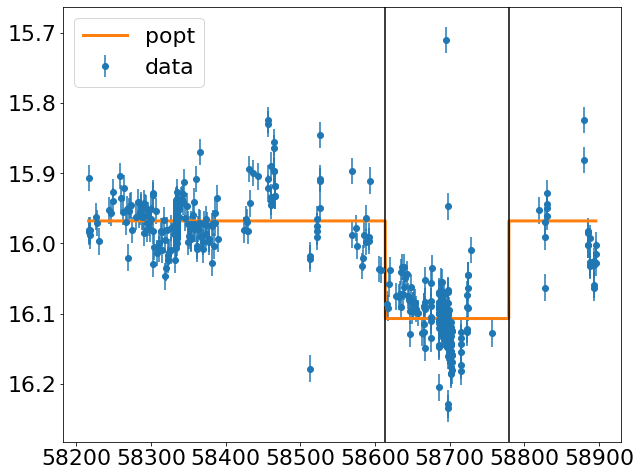


    id                       = 108332829135592126
    dip.significance         = 20.862224578857422
    model_error_around_dip_r = 2.6100456714630127
    


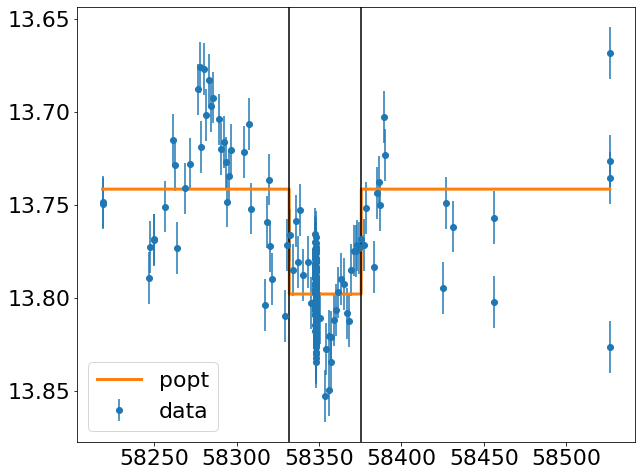


    id                       = 121931751919216995
    dip.significance         = 20.30562973022461
    model_error_around_dip_r = 4.190067768096924
    


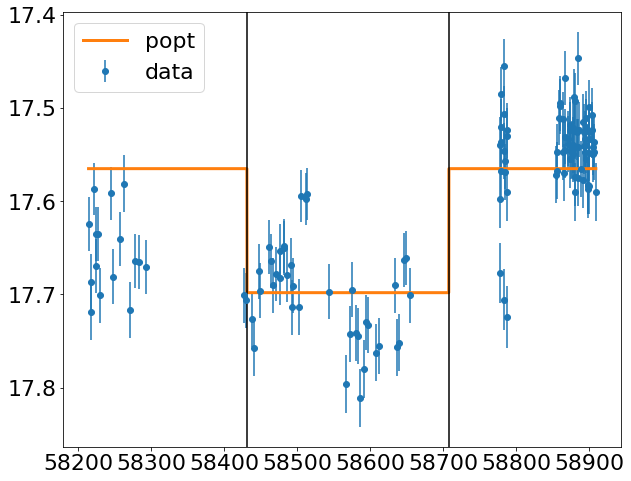


    id                       = 126422474414525943
    dip.significance         = 20.292137145996094
    model_error_around_dip_r = 4.320161819458008
    


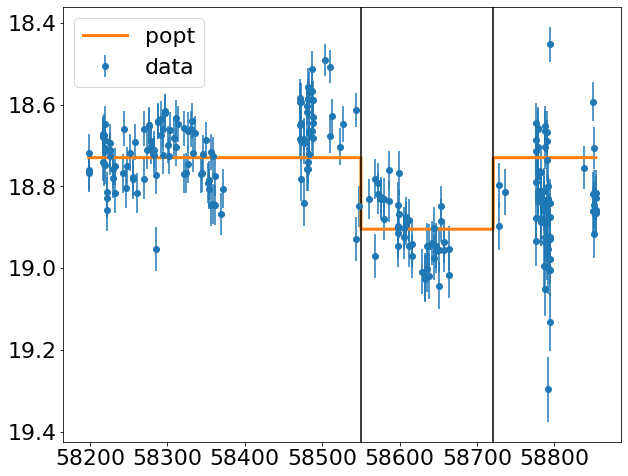


    id                       = 119492926502110462
    dip.significance         = 20.292091369628906
    model_error_around_dip_r = 2.314232587814331
    


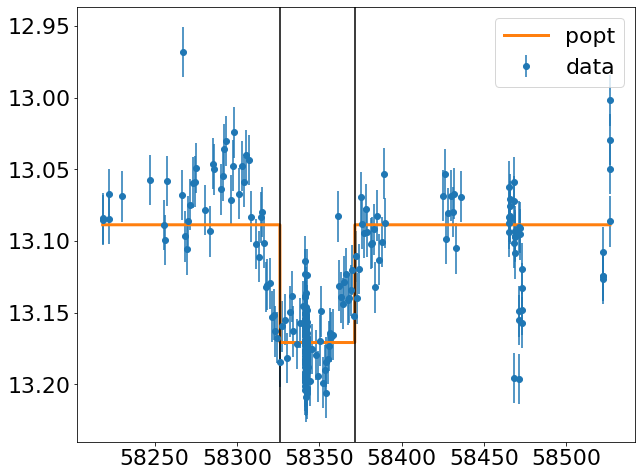


    id                       = 125541035785771616
    dip.significance         = 20.163667678833008
    model_error_around_dip_r = 1.660910964012146
    


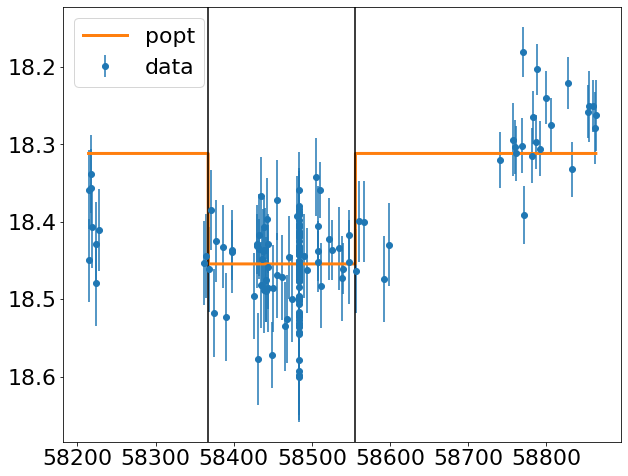


    id                       = 125541035785771616
    dip.significance         = 20.163667678833008
    model_error_around_dip_r = 1.660910964012146
    


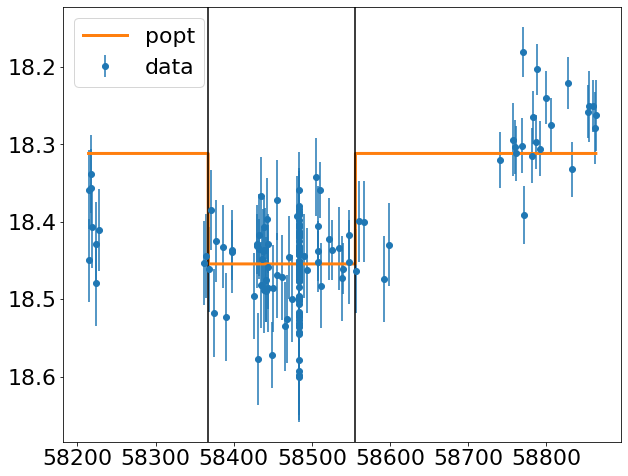


    id                       = 164253065576452667
    dip.significance         = 20.04683494567871
    model_error_around_dip_r = 4.766421318054199
    


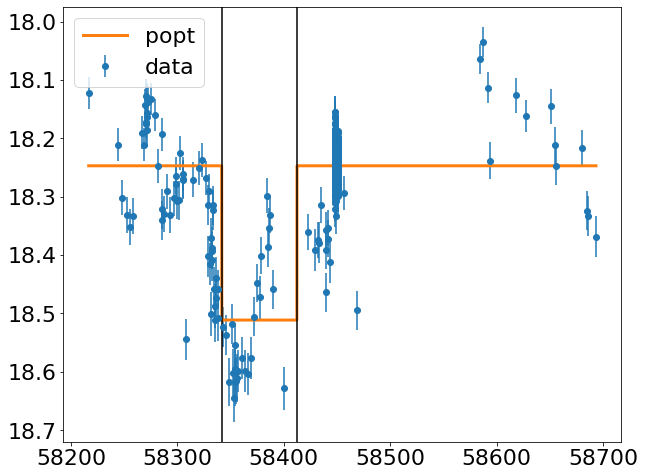


    id                       = 104042840556744533
    dip.significance         = 19.854244232177734
    model_error_around_dip_r = 3.064319133758545
    


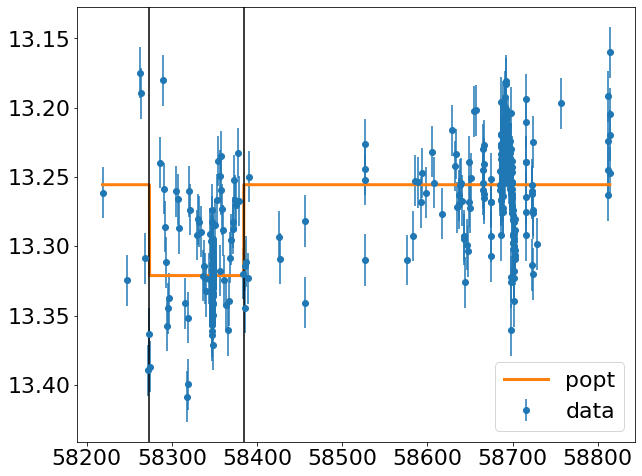


    id                       = 175643379705894050
    dip.significance         = 19.829299926757812
    model_error_around_dip_r = 4.70194673538208
    


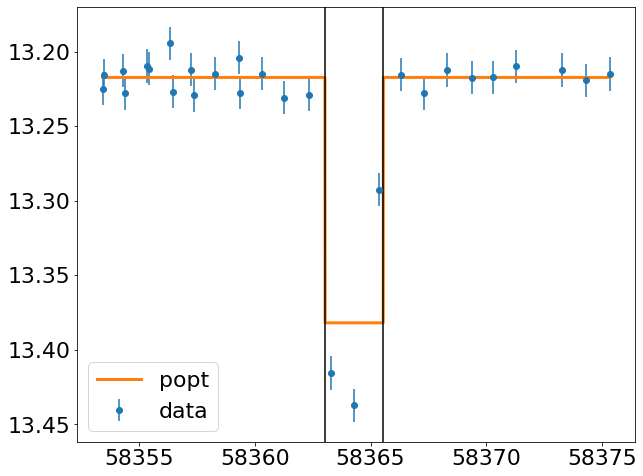


    id                       = 129043063441825291
    dip.significance         = 19.670913696289062
    model_error_around_dip_r = 3.66690993309021
    


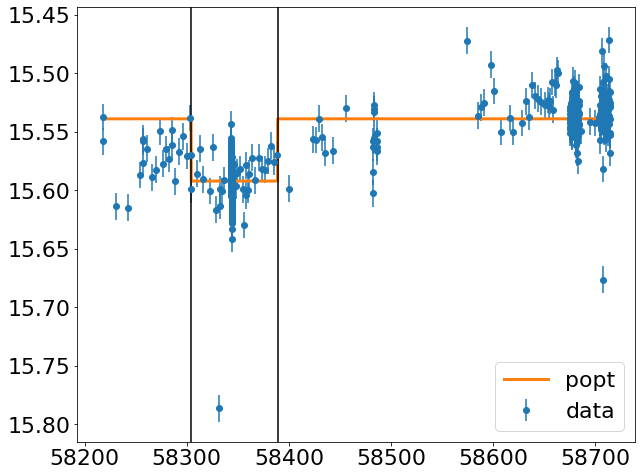


    id                       = 158083291414519139
    dip.significance         = 19.43265724182129
    model_error_around_dip_r = 4.460987091064453
    


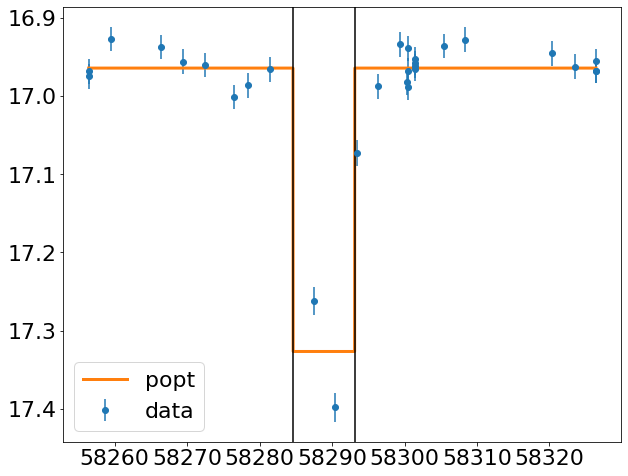


    id                       = 129682933169046994
    dip.significance         = 19.354705810546875
    model_error_around_dip_r = 4.568978786468506
    


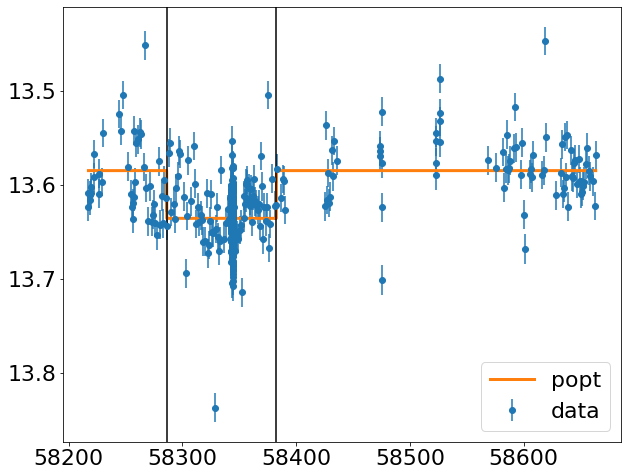


    id                       = 108392864789623912
    dip.significance         = 19.261560440063477
    model_error_around_dip_r = 3.025148868560791
    


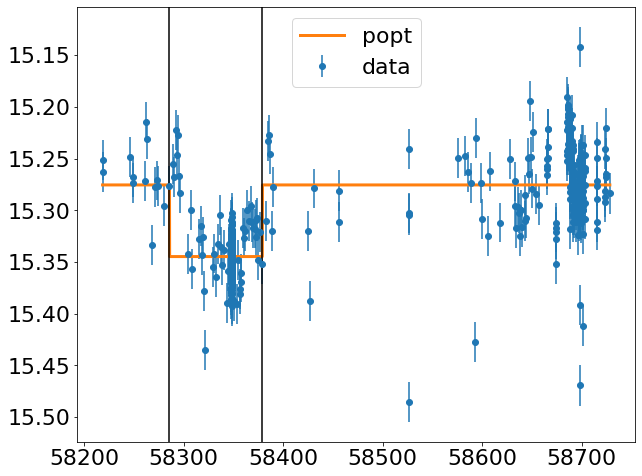


    id                       = 127343016618770972
    dip.significance         = 19.190475463867188
    model_error_around_dip_r = 3.513103485107422
    


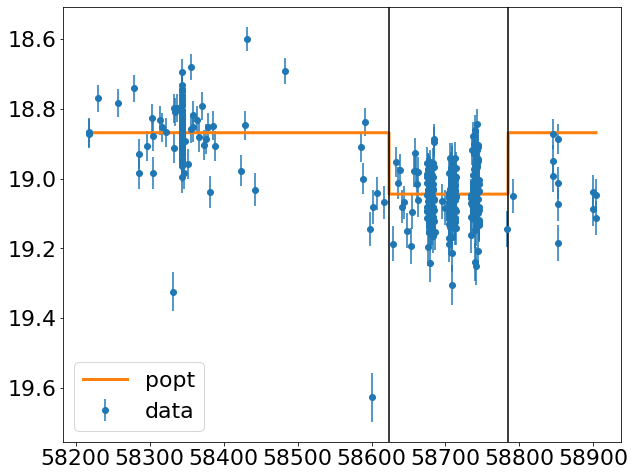


    id                       = 127343016618770972
    dip.significance         = 19.190475463867188
    model_error_around_dip_r = 3.513103485107422
    


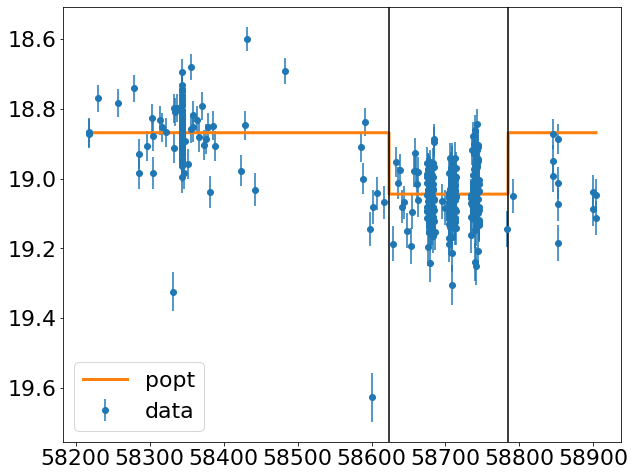


    id                       = 142951535606684356
    dip.significance         = 18.914077758789062
    model_error_around_dip_r = 1.4370582103729248
    


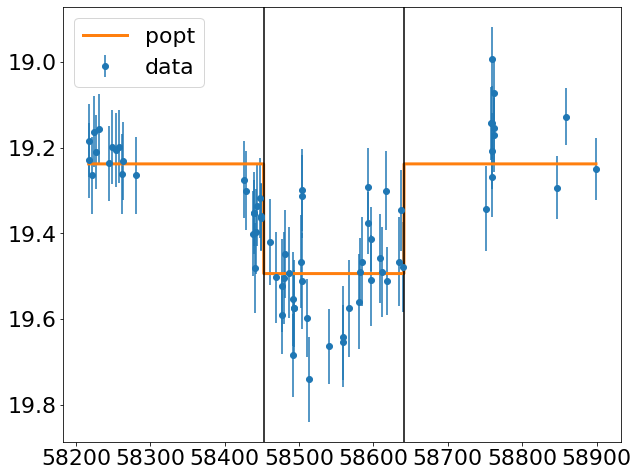


    id                       = 105022809568523298
    dip.significance         = 18.83299446105957
    model_error_around_dip_r = 3.5949108600616455
    


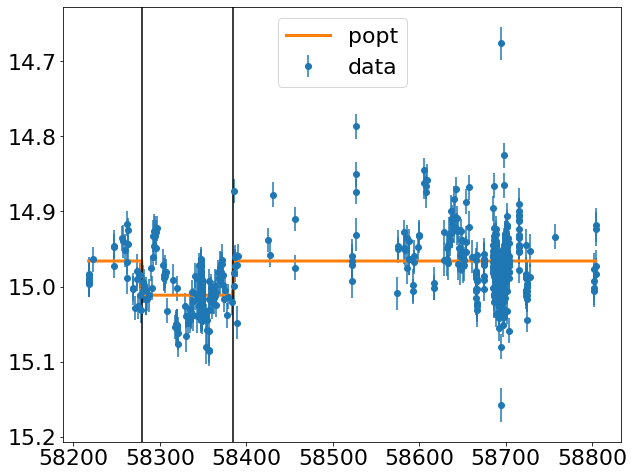


    id                       = 105022809568523298
    dip.significance         = 18.83299446105957
    model_error_around_dip_r = 3.5949108600616455
    


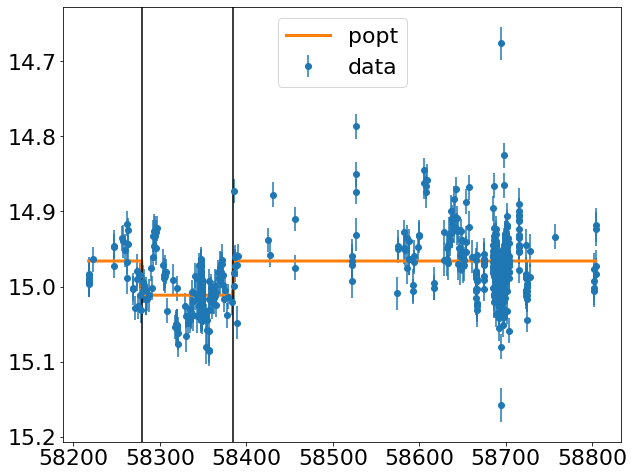


    id                       = 105022809571373313
    dip.significance         = 18.80103874206543
    model_error_around_dip_r = 3.8299715518951416
    


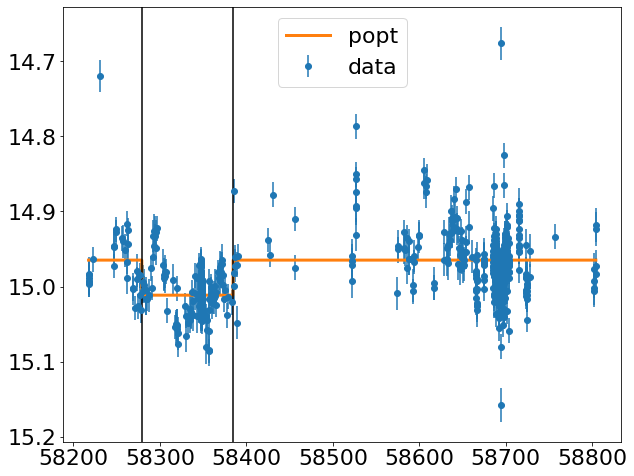


    id                       = 105022809571373313
    dip.significance         = 18.80103874206543
    model_error_around_dip_r = 3.8299715518951416
    


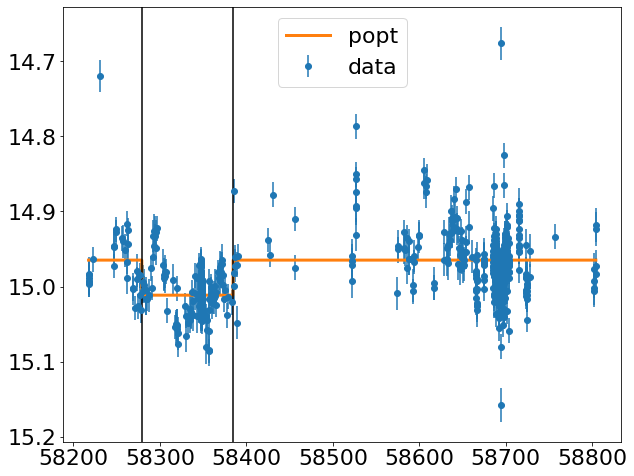


    id                       = 165071177229185619
    dip.significance         = 18.708332061767578
    model_error_around_dip_r = 4.985328197479248
    


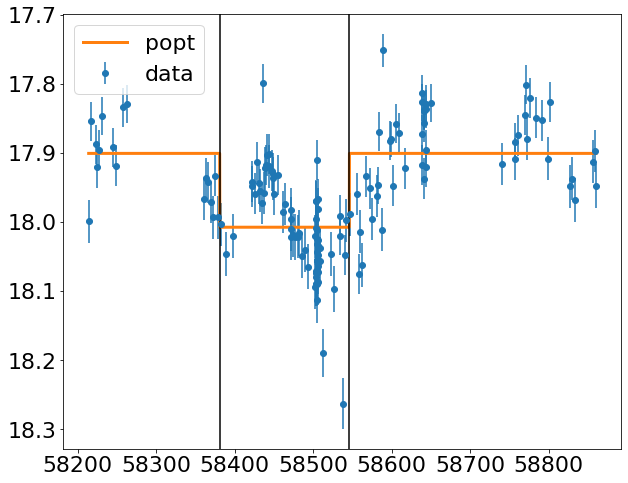


    id                       = 86772788603079957
    dip.significance         = 18.61186981201172
    model_error_around_dip_r = 3.8940987586975098
    


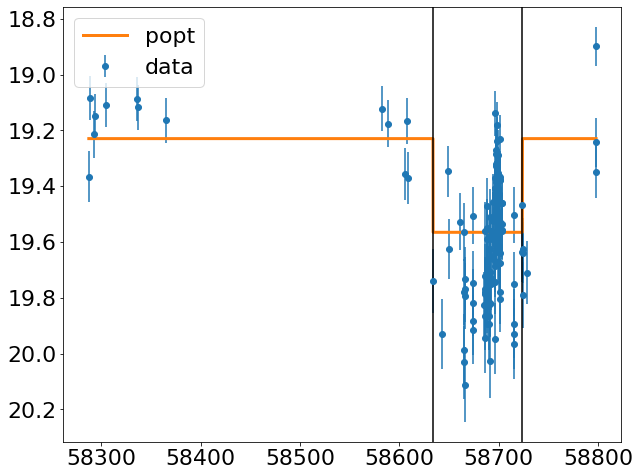


    id                       = 108632911328657047
    dip.significance         = 18.58343505859375
    model_error_around_dip_r = 2.205725908279419
    


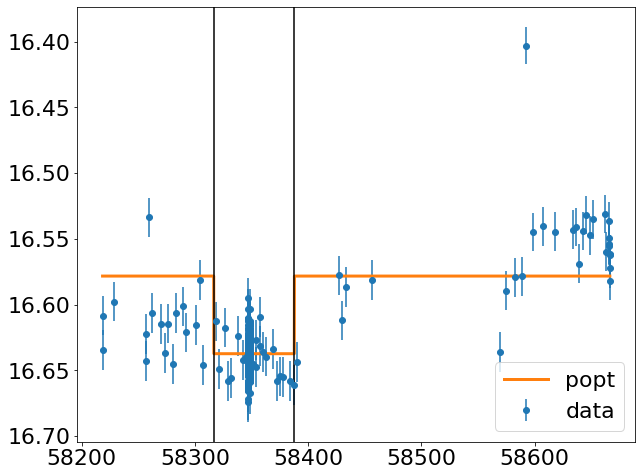


    id                       = 121352755201084082
    dip.significance         = 18.57744598388672
    model_error_around_dip_r = 2.3287806510925293
    


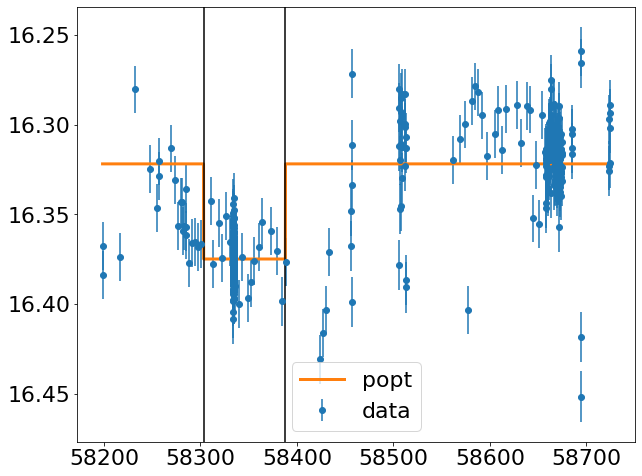


    id                       = 137710901633851633
    dip.significance         = 18.418556213378906
    model_error_around_dip_r = 2.7884767055511475
    


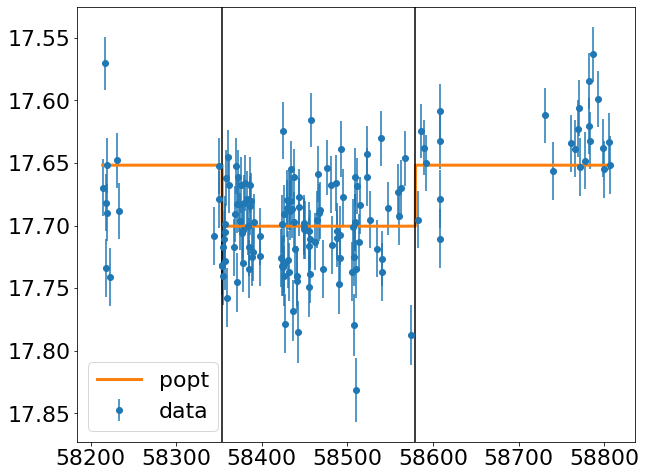


    id                       = 118512777307175662
    dip.significance         = 18.082256317138672
    model_error_around_dip_r = 4.912250995635986
    


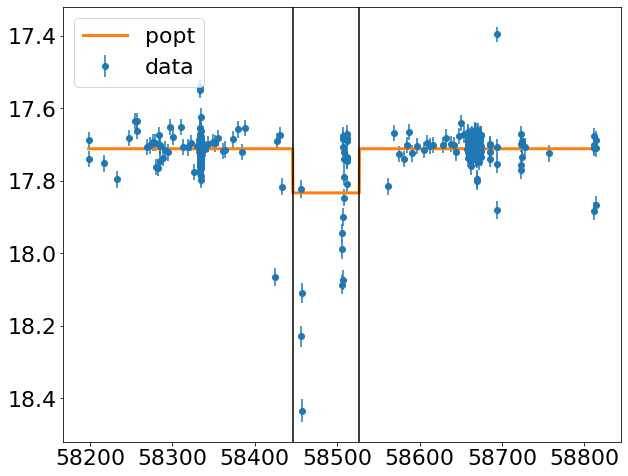


    id                       = 103612832430382320
    dip.significance         = 18.079801559448242
    model_error_around_dip_r = 4.029053688049316
    


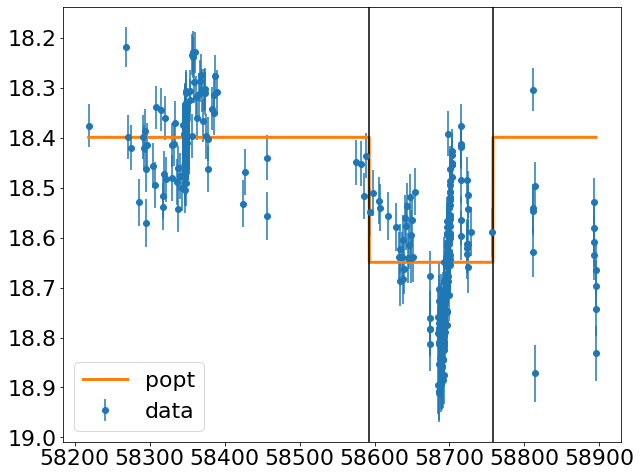


    id                       = 161803137966395478
    dip.significance         = 18.014925003051758
    model_error_around_dip_r = 1.2339348793029785
    


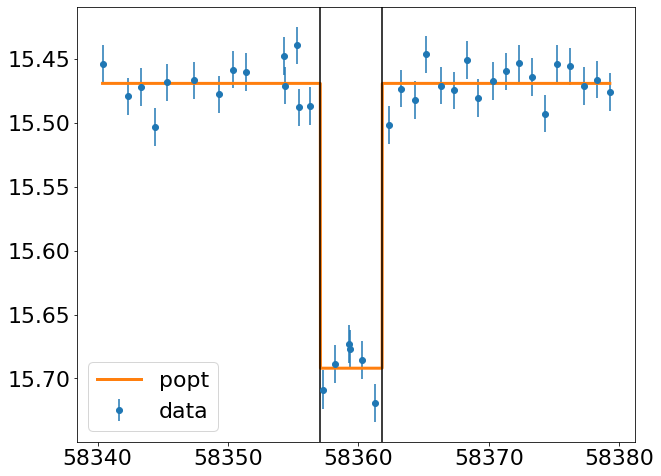


    id                       = 111052903936515355
    dip.significance         = 18.00975799560547
    model_error_around_dip_r = 2.867896795272827
    


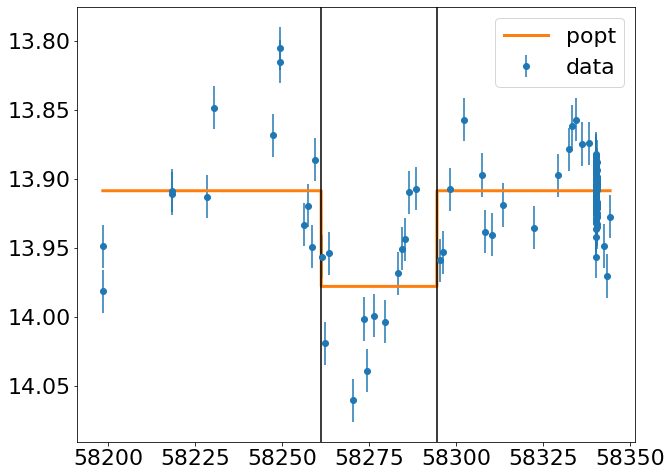


    id                       = 119202930714982704
    dip.significance         = 17.98663902282715
    model_error_around_dip_r = 2.586615562438965
    


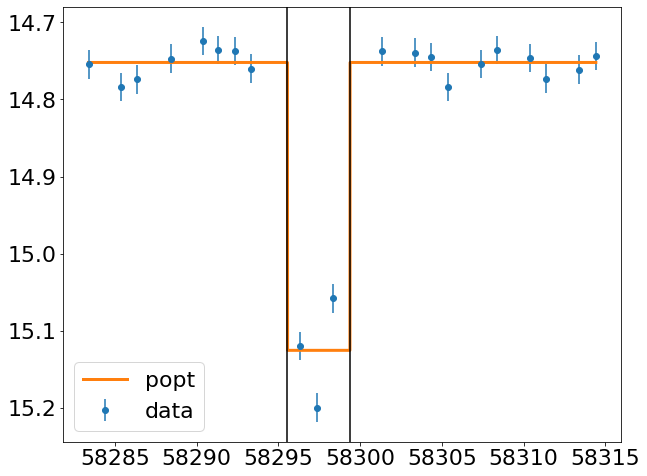


    id                       = 119202930714982704
    dip.significance         = 17.98663902282715
    model_error_around_dip_r = 2.586615562438965
    


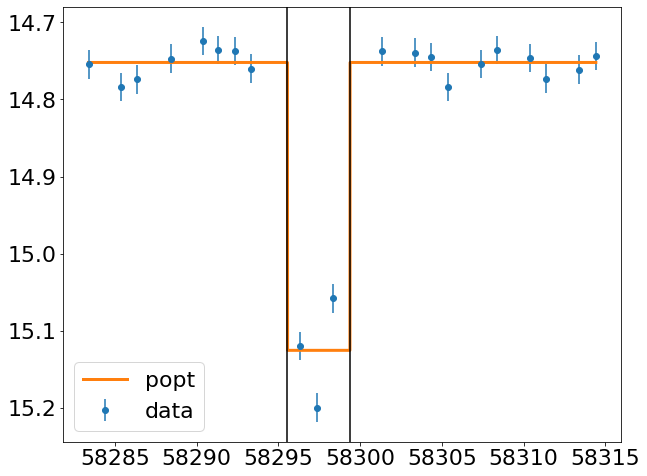


    id                       = 107272901870405875
    dip.significance         = 17.9190673828125
    model_error_around_dip_r = 4.686595916748047
    


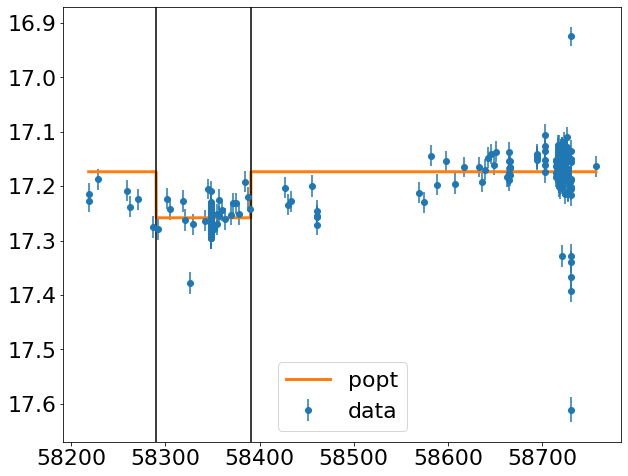


    id                       = 134970965695389322
    dip.significance         = 17.910097122192383
    model_error_around_dip_r = 4.463435649871826
    


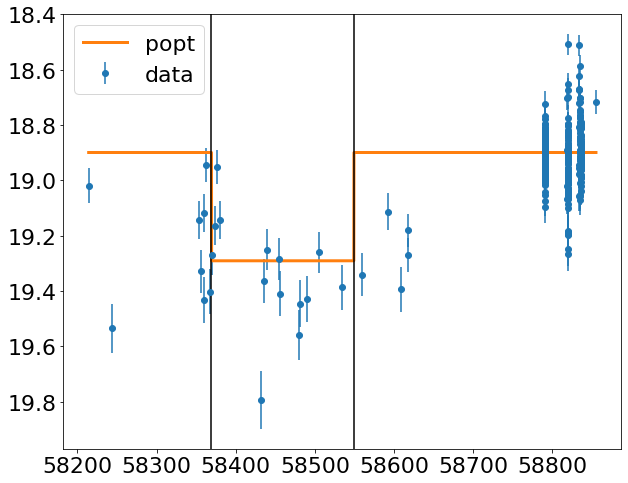


    id                       = 138802936329515815
    dip.significance         = 17.80815315246582
    model_error_around_dip_r = 0.9259543418884277
    


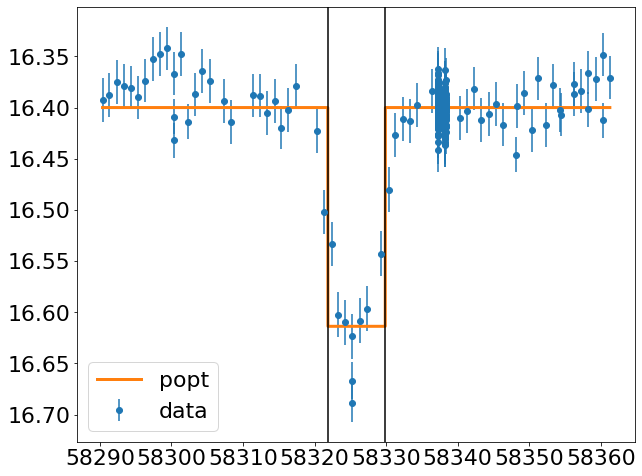


    id                       = 125122854976880353
    dip.significance         = 17.787141799926758
    model_error_around_dip_r = 1.9602805376052856
    


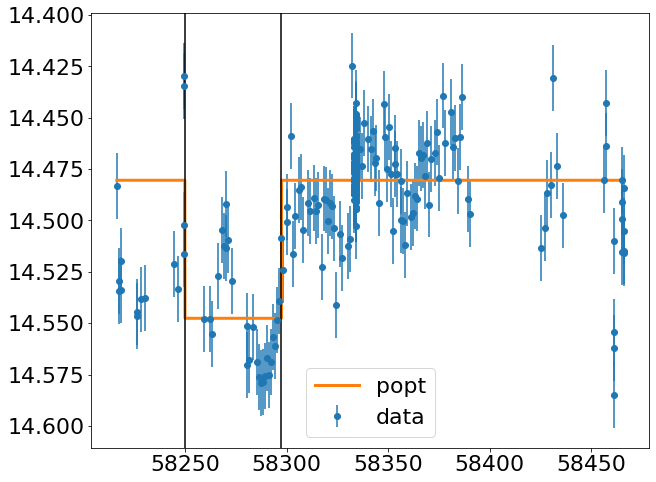


    id                       = 139171471555890328
    dip.significance         = 17.78385353088379
    model_error_around_dip_r = 4.3513641357421875
    


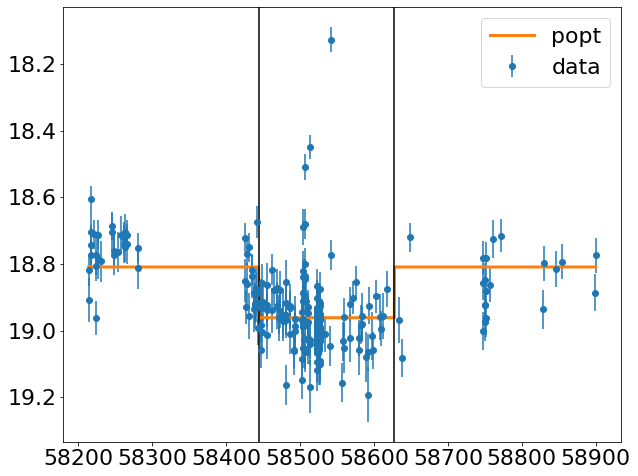


    id                       = 163583138607224078
    dip.significance         = 17.726512908935547
    model_error_around_dip_r = 4.233964443206787
    


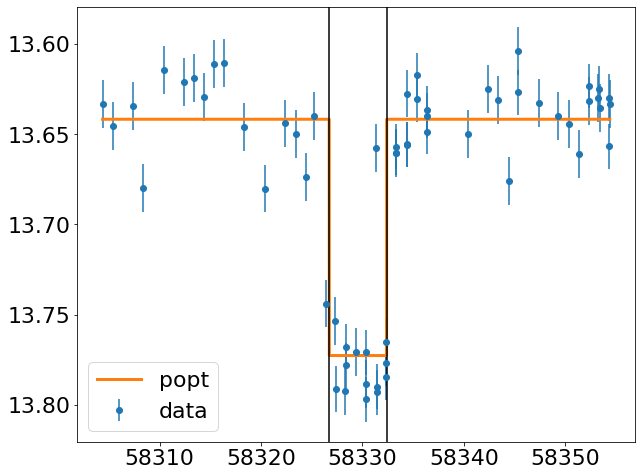


    id                       = 100552919249654906
    dip.significance         = 17.691757202148438
    model_error_around_dip_r = 4.991517066955566
    


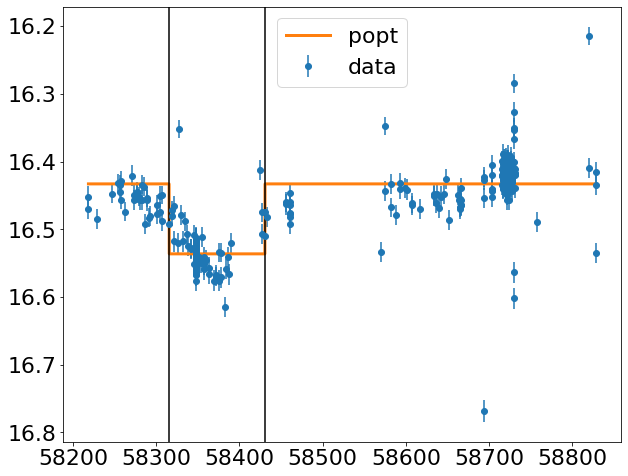


    id                       = 118022851262879473
    dip.significance         = 17.62985610961914
    model_error_around_dip_r = 3.4262149333953857
    


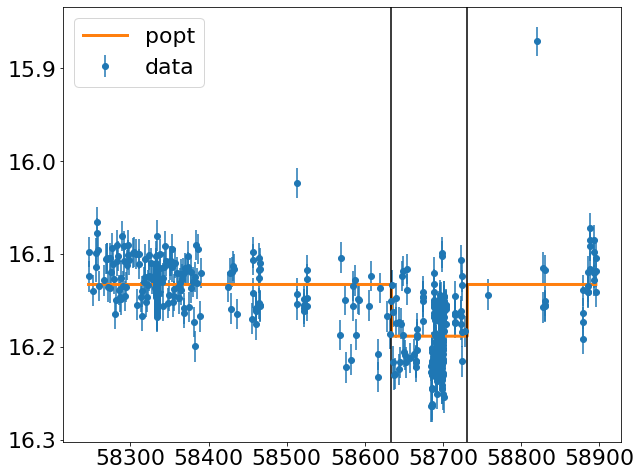


    id                       = 159171011493366577
    dip.significance         = 17.554399490356445
    model_error_around_dip_r = 1.1806446313858032
    


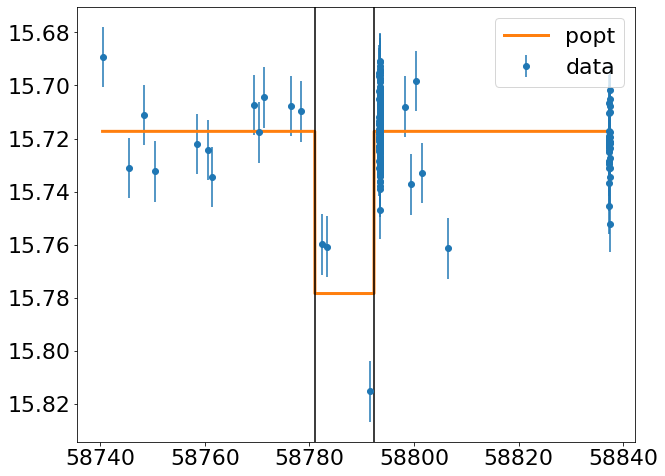


    id                       = 101710817453827641
    dip.significance         = 17.51239776611328
    model_error_around_dip_r = 1.2866795063018799
    


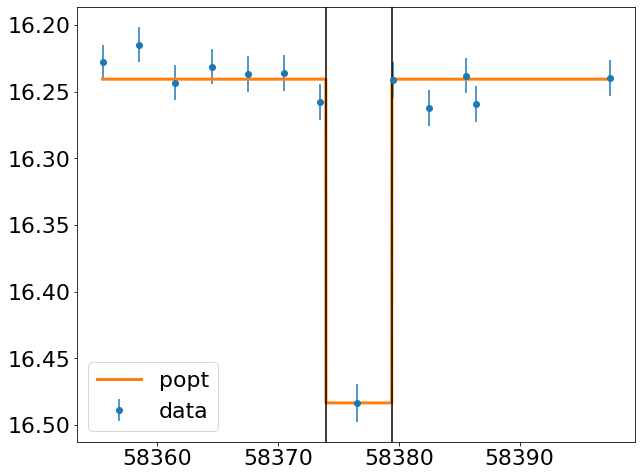


    id                       = 181733509226591414
    dip.significance         = 17.49847984313965
    model_error_around_dip_r = 2.1697373390197754
    


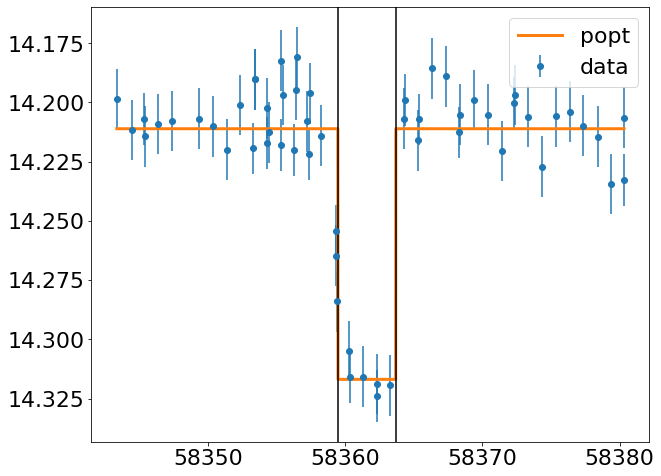


    id                       = 153011419725000544
    dip.significance         = 17.49786949157715
    model_error_around_dip_r = 2.7777159214019775
    


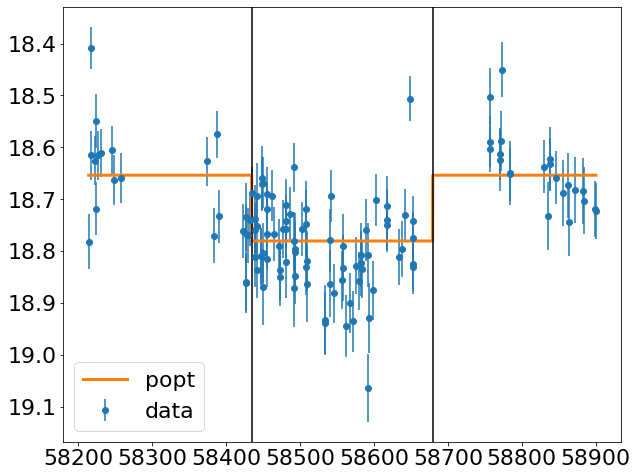


    id                       = 102822815473135089
    dip.significance         = 17.497100830078125
    model_error_around_dip_r = 3.379530429840088
    


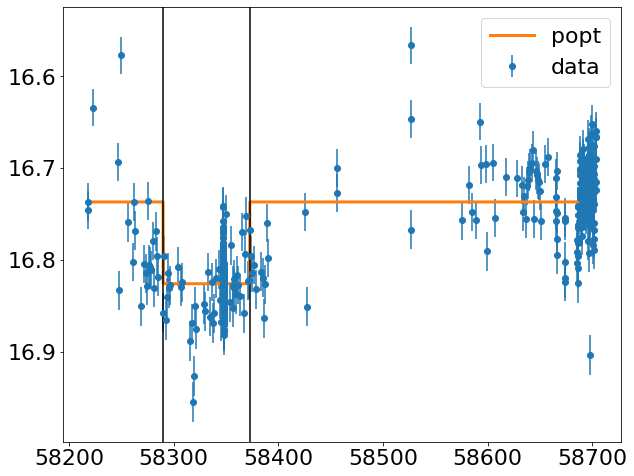


    id                       = 160232216918453999
    dip.significance         = 17.438514709472656
    model_error_around_dip_r = 4.165630340576172
    


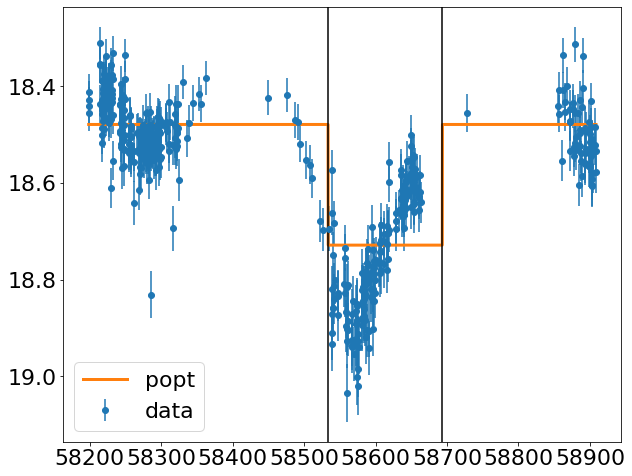


    id                       = 125012881773328025
    dip.significance         = 17.386470794677734
    model_error_around_dip_r = 4.874828338623047
    


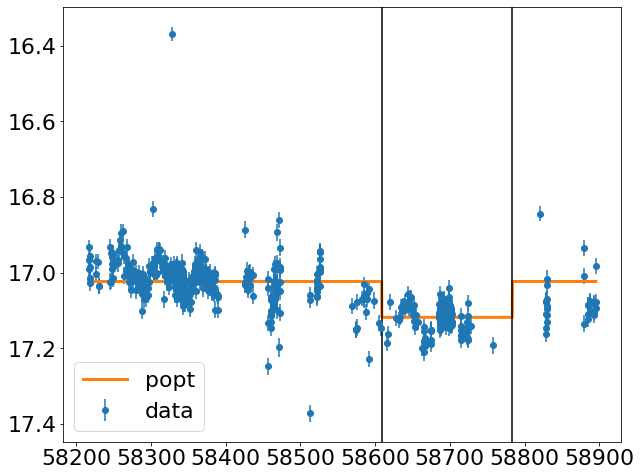


    id                       = 120452805834061063
    dip.significance         = 17.374521255493164
    model_error_around_dip_r = 3.4137122631073
    


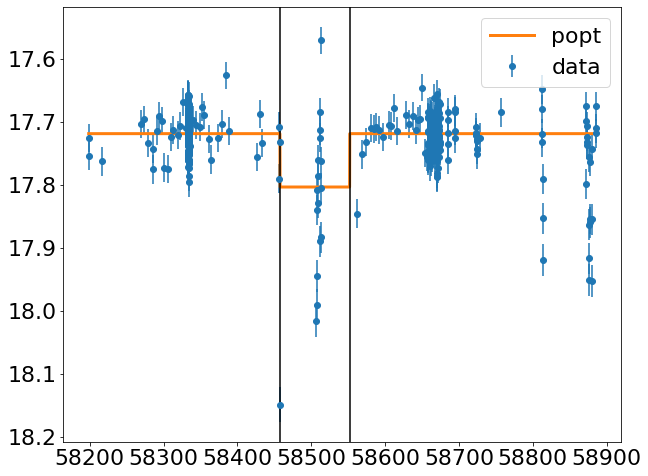


    id                       = 101852777145664335
    dip.significance         = 17.27921485900879
    model_error_around_dip_r = 4.2926716804504395
    


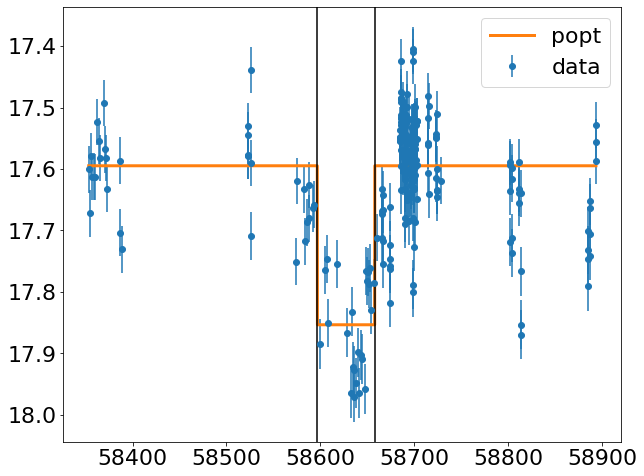


    id                       = 128142989138855223
    dip.significance         = 17.250850677490234
    model_error_around_dip_r = 2.20163631439209
    


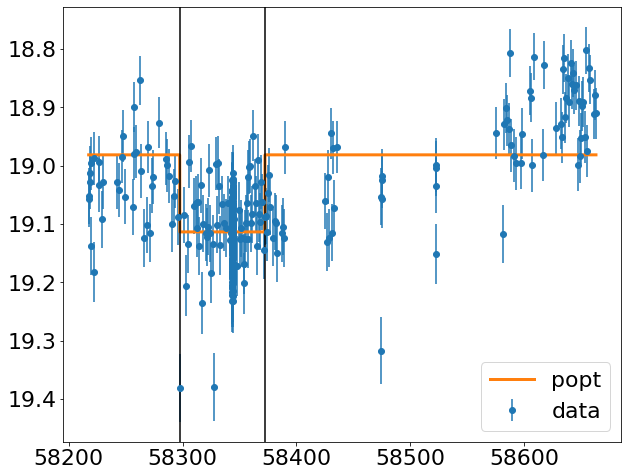


    id                       = 184460213361120575
    dip.significance         = 17.241430282592773
    model_error_around_dip_r = 1.7350924015045166
    


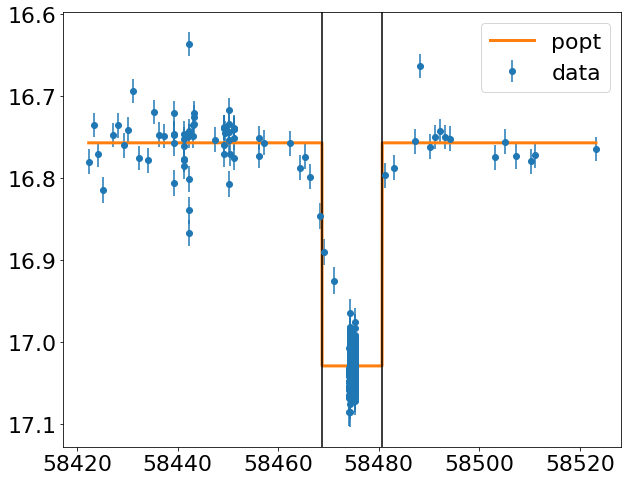


    id                       = 149482979542655999
    dip.significance         = 17.194168090820312
    model_error_around_dip_r = 3.248539447784424
    


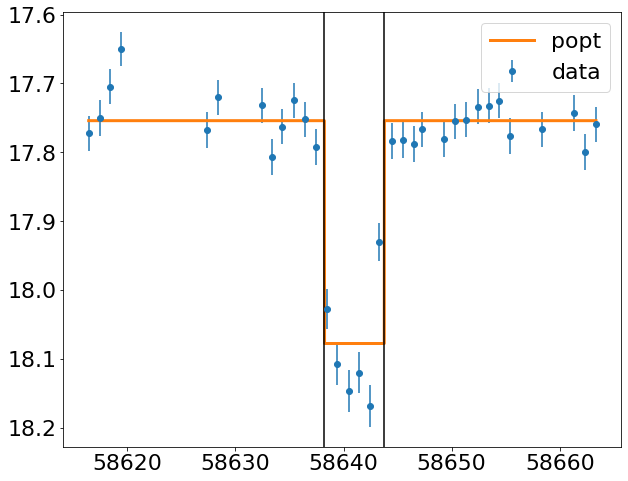


    id                       = 126182753999180746
    dip.significance         = 17.17770767211914
    model_error_around_dip_r = 2.8243424892425537
    


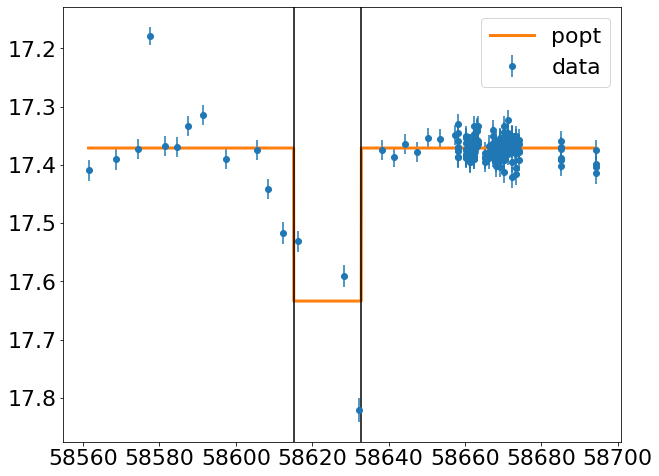


    id                       = 126182753999180746
    dip.significance         = 17.17770767211914
    model_error_around_dip_r = 2.8243424892425537
    


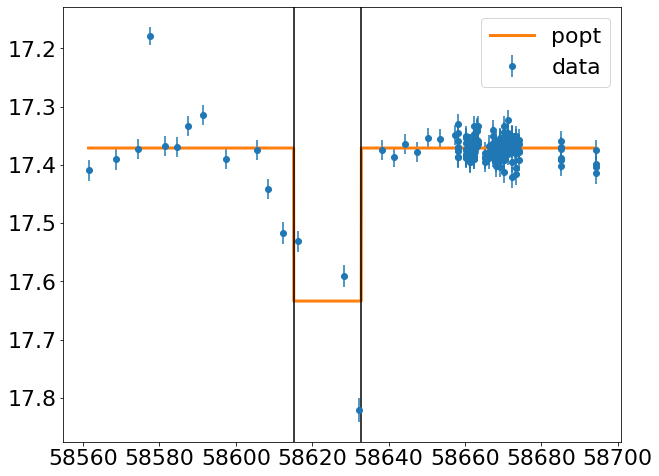


    id                       = 136622962523299505
    dip.significance         = 17.17356300354004
    model_error_around_dip_r = 2.292407274246216
    


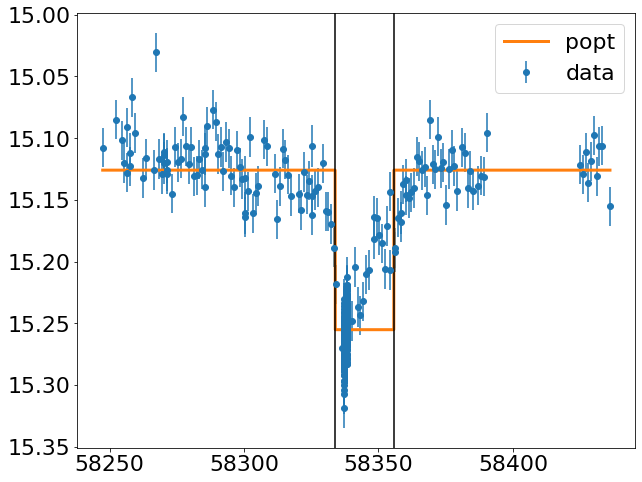


    id                       = 190333596921288920
    dip.significance         = 17.169721603393555
    model_error_around_dip_r = 2.6852681636810303
    


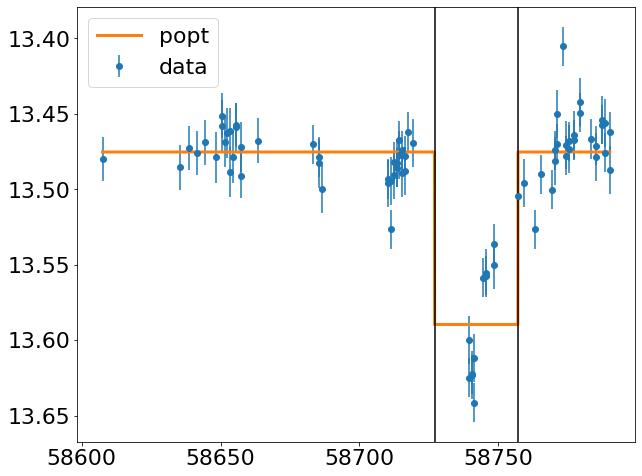


    id                       = 105072849836219274
    dip.significance         = 17.15682601928711
    model_error_around_dip_r = 1.8853236436843872
    


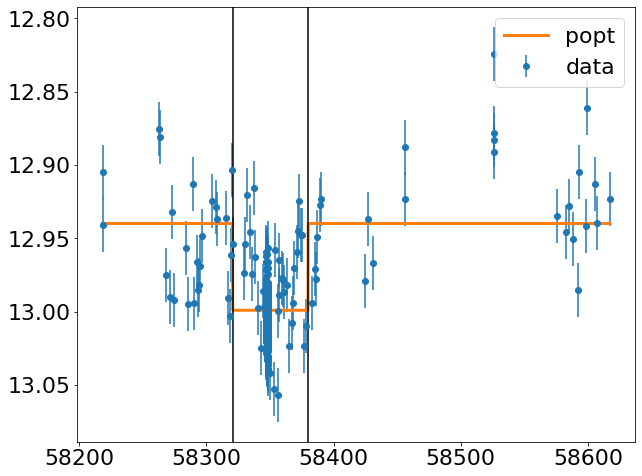


    id                       = 150812905494789157
    dip.significance         = 17.109140396118164
    model_error_around_dip_r = 3.1480026245117188
    


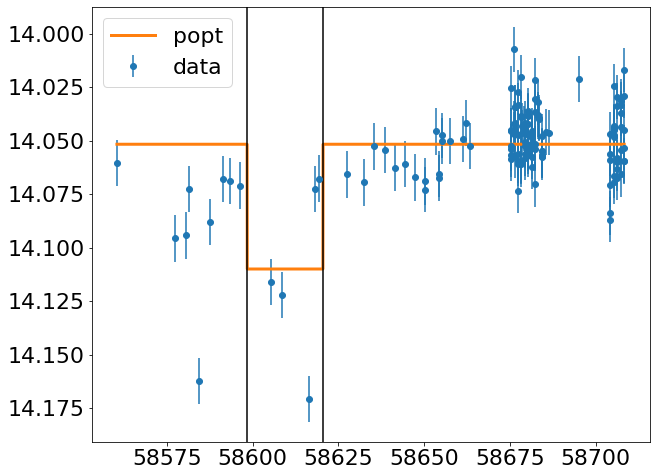


    id                       = 122692831843266383
    dip.significance         = 17.069808959960938
    model_error_around_dip_r = 3.316634178161621
    


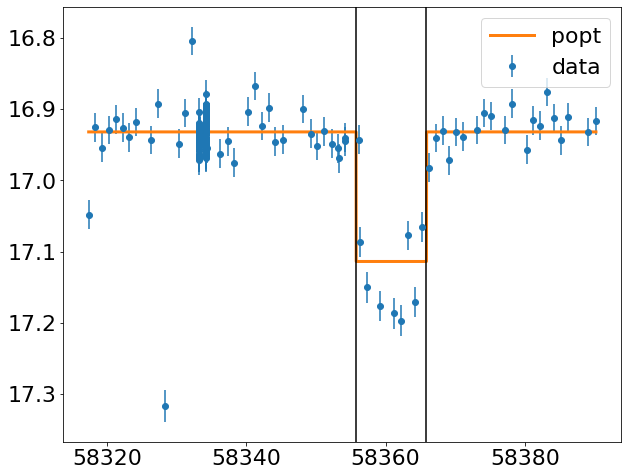


    id                       = 106712866163044826
    dip.significance         = 17.06188201904297
    model_error_around_dip_r = 2.285193920135498
    


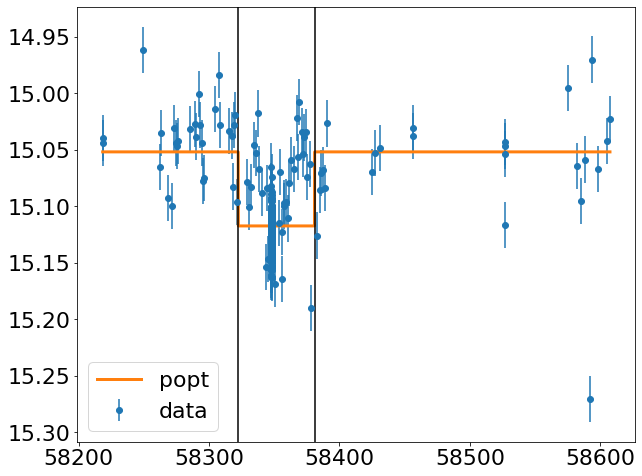


    id                       = 181553588080059127
    dip.significance         = 16.994104385375977
    model_error_around_dip_r = 3.620140552520752
    


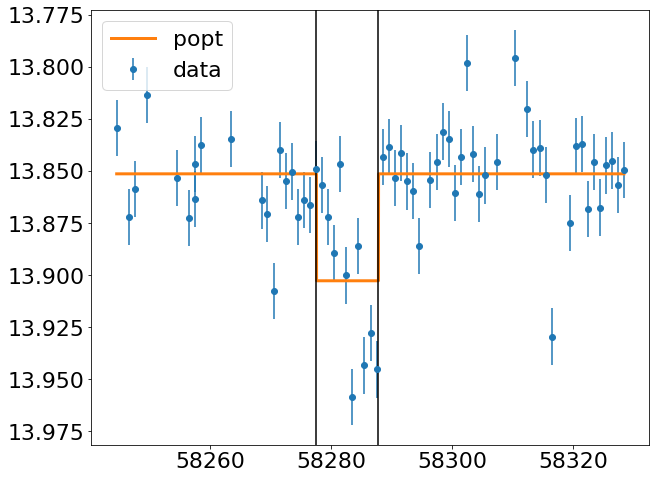


    id                       = 169713230265413179
    dip.significance         = 16.991493225097656
    model_error_around_dip_r = 2.905352830886841
    


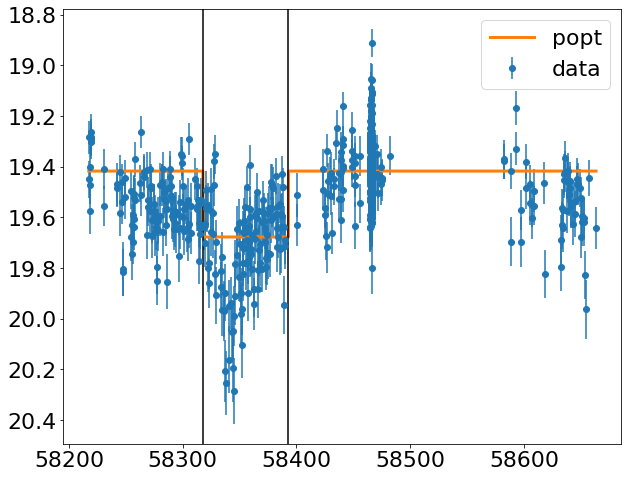


    id                       = 106312837045252111
    dip.significance         = 16.94841957092285
    model_error_around_dip_r = 2.4110107421875
    


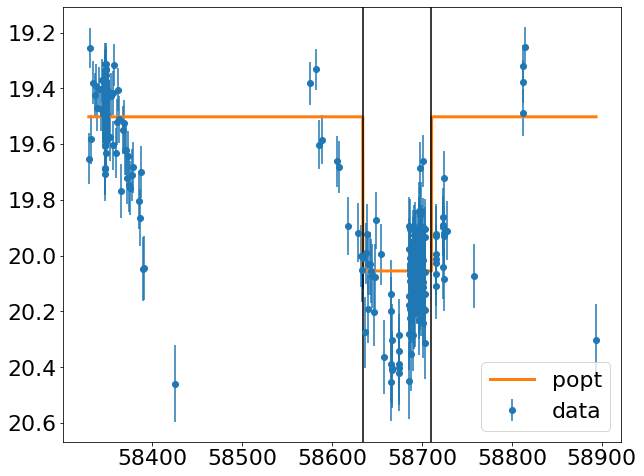


    id                       = 88952703446803220
    dip.significance         = 16.93505096435547
    model_error_around_dip_r = 3.214974880218506
    


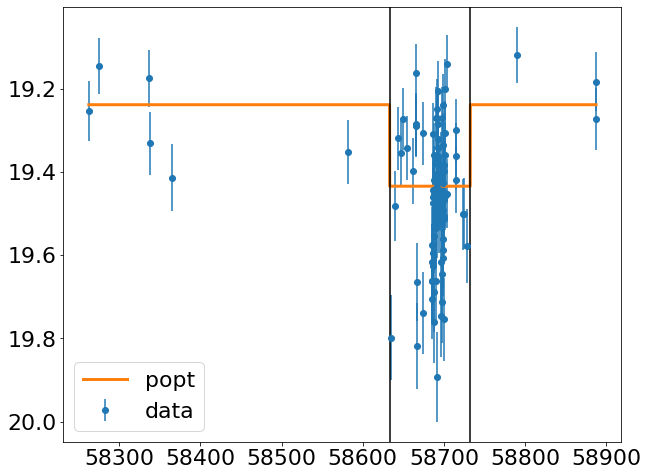


    id                       = 118602800162527752
    dip.significance         = 16.915674209594727
    model_error_around_dip_r = 4.420711517333984
    


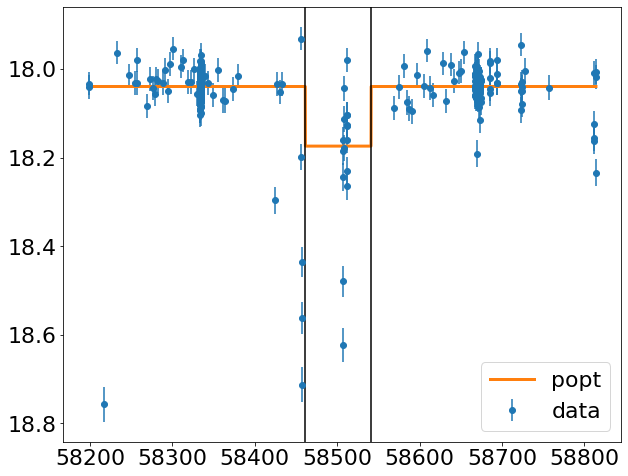


    id                       = 160981391005436381
    dip.significance         = 16.911653518676758
    model_error_around_dip_r = 2.091615915298462
    


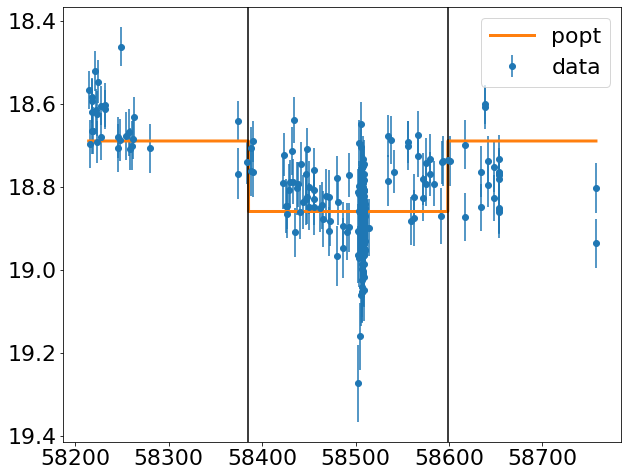


    id                       = 152252898830577354
    dip.significance         = 16.875385284423828
    model_error_around_dip_r = 1.7658976316452026
    


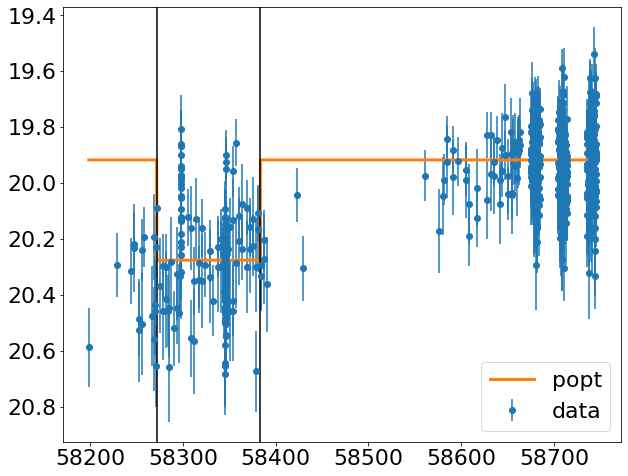


    id                       = 126352766089351179
    dip.significance         = 16.846038818359375
    model_error_around_dip_r = 3.640984058380127
    


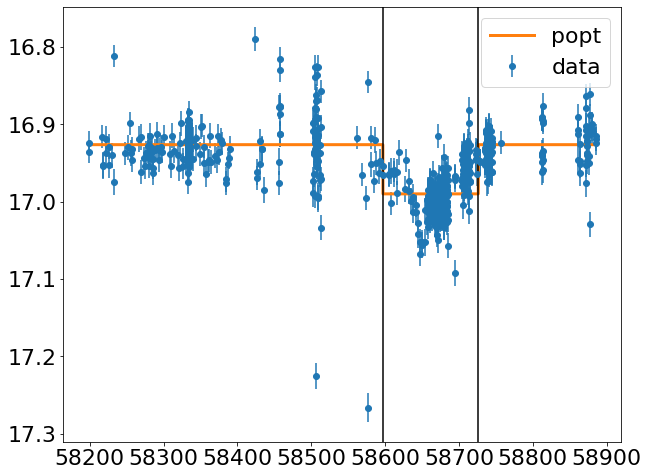


    id                       = 132740979594745180
    dip.significance         = 16.763519287109375
    model_error_around_dip_r = 3.845280170440674
    


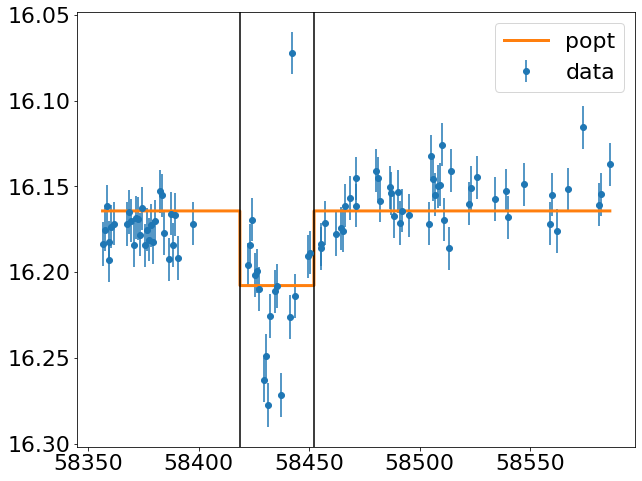


    id                       = 83662660304131503
    dip.significance         = 16.757225036621094
    model_error_around_dip_r = 4.928715705871582
    


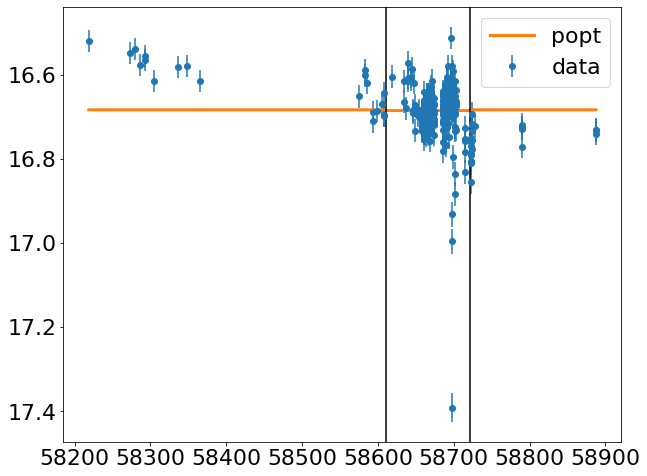


    id                       = 83662660304131503
    dip.significance         = 16.757225036621094
    model_error_around_dip_r = 4.928715705871582
    


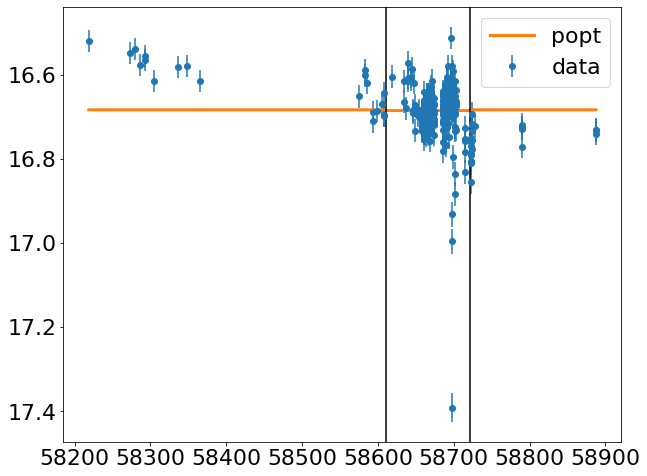

In [40]:
nplot = 0
total = 100
for lc in fits_to_show_window_error_in_memory:
    if nplot == total:
        break
    x = lc['around_dip_window_r']['x']
    nplot += 1
        
    y = lc['around_dip_window_r']['y']
    yerr = lc['around_dip_window_r']['yerr']
    fit = lc['fit_r']
    plot_fit_result(
        x, y, yerr, 
        fit, top_hat
    )

    dip = lc['dip']
    
    plt.axvline(dip['start_mjd'], color="k", label="start")
    plt.axvline(dip['end_mjd'], color="k", label="end")
    print("""
    id                       = {}
    dip.significance         = {}
    model_error_around_dip_r = {}
    """.format(
        lc['ps1_objid'],
        dip['significance'],
        lc['model_error_around_dip_r']['reduced_sum_square_error']
    ))
    
    plt.gca().invert_yaxis()
    plt.show()